Exploratory analysis of releasing particles near a topographic boundary

To characterize the interaction of the flow with a complex topography like a coral reef, I am going to release particles near the boundary and track them forwards and backwards in time. This notebook is designed to outline a structure for the study.
First let's import the necessary modules

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "\\Users\\Gebruiker\\Documents\\GitHub\\parcels\\")  # Set path to find the newest parcels code

from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4_3D, ErrorCode, plotTrajectoriesFile
import numpy as np
from operator import attrgetter
from datetime import timedelta
from netCDF4 import Dataset,num2date,date2num
from explfunctions import deleteparticle, removeNaNs, FinalDistance

Now we are going to obtain flowfields in netcdf form. Because the general 2D structure in Parcels expects lon-lat, while these flowfield are 1D and depth, we are going to transform the data, add a dimension and use from_data to read in the 3D flow fields. This also sets up further research in 3D. Here we decide which flow we are going to analyse and whether to do it forwards or backwards in time

In [2]:
filename = 'output-corals-regridded'
fb = 'backward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
corald = Dataset(filename+'.nc','r+') # read netcdf file with input

# Extract all variables into np arrays --> in the future xarray will be used
T = corald.variables['T'][:]
X = corald.variables['X'][:]
Y = corald.variables['Y'][:]
U = corald.variables['U'][:]
V = corald.variables['V'][:]

corald.close()

Here the variables are going to be changed to fit parcels

In [3]:
U = np.asarray(U)
U = np.expand_dims(U,2)            # add a third dimension

V = np.asarray(V)
V = np.expand_dims(V,2)            # add a third dimension

t = num2date(T,units='seconds since 2000-01-01 00:00:00.0') # make t a datetime object
t = date2num(t,units='seconds since 2000-01-01 00:00:00.0')

times = t
xs = X
ys = np.asarray([-1,0,1])          # third dimension with length 3. 2D flow field will be inserted on the middle value to ensure the AdvectionRK4_3D works correctly
depths = -Y                        # Y was height, but parcels expects depth

u = np.zeros(U.shape)
u = np.concatenate((u,u,u),axis=2) # add the third dimension
u[:,:,1,:] = U[:,:,0,:]            # add the data to the middle value of the third dimension
v = np.zeros(u.shape)
w = np.zeros(U.shape)
w = np.concatenate((w,w,w),axis=2) # add the third dimension
w[:,:,1,:] = -V[:,:,0,:]           # because depth = -Y, w = -V

dist = np.zeros(u.shape)
coralmap = np.load('coralmap.npy')
dist[:,:,1,:] = np.asarray([coralmap]*len(u))

Now we are going to read the data into a parcels fieldset using FieldSet.from_data.

In [4]:
data = {'U': u,
        'V': v,
        'W': w,
        'D': dist}
dimensions = {'lon':xs,
              'lat':ys,
              'depth':depths,
              'time':times}
fieldset = FieldSet.from_data(data=data, dimensions= dimensions, mesh='flat')

In [ ]:
class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    finaldistance = Variable('finaldistance', initial=0., dtype=np.float32)  # the distance travelled
    prevlon = Variable('prevlon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prevlat = Variable('prevlat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    prevdepth = Variable('prevdepth', dtype=np.float32, to_write=False,
                        initial=attrgetter('depth'))  # the previous latitude.
    d2c = Variable('d2c', dtype=np.float32, initial=fieldset.D)
    
def SampleD(particle, fieldset, time):  # Custom function that samples fieldset.P at particle location
    particle.d2c = fieldset.D[time, particle.depth, particle.lat, particle.lon]

Now that the data are read into a fieldset object, we want to define the attributes of the particles we are going to release as a particleset object. In this experiment, we want to release particles at all gridpoints in the model, except for the ones where coral geometrical objects are in the flow. Also, we want to define for how long the particles are advected, which timestep to use and what output to obtain.

In [6]:
lons, ds = np.meshgrid(xs,depths)                        # meshgrid at all gridpoints in the flow data
um = np.ma.masked_invalid(u[0,:,1,:])                    # retrieve mask from flowfield to take out points over coral objects

lons = np.ma.masked_array(lons,mask=um.mask)             # mask points in meshgrid
lons = lons.flatten()
ds = np.ma.masked_array(ds,mask=um.mask)                 # mask points in meshgrid
ds = ds.flatten()

outputdt = timedelta(seconds=0.1)                        # timesteps to create output at
dt=timedelta(seconds=0.01)                               # timesteps to calculate particle trajectories
runtime=timedelta(seconds=10)                            # total time to execute the particleset
lats = np.asarray([0]*len(lons))                         # all particles must start and stay on the middle value of the extra dimension
inittime = np.asarray([0]*len(lons))                     # default time to start the particles is zero
if fb == 'backward':                                     # change timestep and start time when in 'backward' mode
    dt = dt*-1
    inittime = np.asarray([runtime.seconds]*len(lons))

In [7]:
pset = ParticleSet(fieldset=fieldset, pclass=DistParticle, lon=lons, lat=lats, depth=ds,time=inittime)

The masked values at the coral objects are seen by parcels as zero, so we are going to remove these trajectories. If we do not do this we are calculating many more trajectories which all start at the same time at lon = 0 and depth = 0. The function that does this is removeNaNs in the explfunctions file.

In [8]:
k_removeNaNs = pset.Kernel(removeNaNs)
pset.execute(k_removeNaNs, runtime = timedelta(seconds=0))

INFO: Compiled DistParticleremoveNaNs ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\f122a8c9521af2cff02045bac7d4fc39_0.dll


Aside from the trajectories, we would like to find out which particles are beached, i.e. find themselves on the coral where there are no velocities to advect them. To look at this through time, we have written the function FinalDistance, which saves the distance moved in the last timestep at each output time. If this is zero, we assume the particle to be stuck. The output file is named based on the input file, whether the run is forward or backward in time and the runtime.

In [9]:
k_dist = pset.Kernel(FinalDistance)  # Casting the FinalDistance function to a kernel.
k_sample = pset.Kernel(SampleD)    # Casting the SampleP function to a kernel.
# k_adv = pset.Kernel(AdvectionRK4_3D_v)  # Casting the advection function with velocities to a kernel.

pset.execute(AdvectionRK4_3D+k_dist+k_sample,
             runtime=runtime,
             dt=dt,
             recovery = {ErrorCode.ErrorOutOfBounds:deleteparticle},
             output_file=pset.ParticleFile(name=filename+fb+str(runtime.seconds), outputdt=outputdt)
            )


INFO: Compiled DistParticleAdvectionRK4_3DFinalDistanceSampleD ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\aebe4129eb654b9999fe0ce44790dac8_0.dll


Particle 0 has died at t = 10.0 at lon, lat, depth = -0.5, 0.0, -0.49
Particle 1 has died at t = 9.990000000223517 at lon, lat, depth = -0.5, 0.0, -0.49
Particle 2 has died at t = 9.980000000447035 at lon, lat, depth = -0.49999997, 0.0, -0.49
Particle 3 has died at t = 9.970000000670552 at lon, lat, depth = -0.49999997, 0.0, -0.49
Particle 4 has died at t = 9.96000000089407 at lon, lat, depth = -0.49999997, 0.0, -0.49
Particle 5 has died at t = 9.950000001117587 at lon, lat, depth = -0.49999994, 0.0, -0.49
Particle 6 has died at t = 9.940000001341105 at lon, lat, depth = -0.49999994, 0.0, -0.49
Particle 7 has died at t = 9.930000001564622 at lon, lat, depth = -0.49999994, 0.0, -0.49
Particle 8 has died at t = 9.92000000178814 at lon, lat, depth = -0.4999999, 0.0, -0.49
Particle 9 has died at t = 9.910000002011657 at lon, lat, depth = -0.4999999, 0.0, -0.49
Particle 806 has died at t = 10.0 at lon, lat, depth = 7.56, 0.0, -0.49
Particle 807 has died at t = 10.0 at lon, lat, depth = 7.57

INFO: Temporary output files are stored in out-IPRSEGOX.
INFO: You can use "parcels_convert_npydir_to_netcdf out-IPRSEGOX" to convert these to a NetCDF file during the run.
N/A% (0 of 10.0) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


Particle 30 has died at t = 9.700000006705523 at lon, lat, depth = -0.4999998, 0.0, -0.49
Particle 31 has died at t = 9.69000000692904 at lon, lat, depth = -0.4999998, 0.0, -0.49
Particle 32 has died at t = 9.680000007152557 at lon, lat, depth = -0.4999998, 0.0, -0.49
Particle 33 has died at t = 9.670000007376075 at lon, lat, depth = -0.4999998, 0.0, -0.49
Particle 34 has died at t = 9.660000007599592 at lon, lat, depth = -0.4999998, 0.0, -0.49
Particle 35 has died at t = 9.65000000782311 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 36 has died at t = 9.640000008046627 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 37 has died at t = 9.630000008270144 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 38 has died at t = 9.620000008493662 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 39 has died at t = 9.61000000871718 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 930 has died at t = 9.700000006705523 at lon, lat, depth = -0.4999998, 0.0, -0.48
Particl

  3% (0.3999999999999986 of 10.0) |      | Elapsed Time: 0:00:03 ETA:   0:01:29


Particle 40 has died at t = 9.600000008940697 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 41 has died at t = 9.590000009164214 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 42 has died at t = 9.580000009387732 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 43 has died at t = 9.570000009611249 at lon, lat, depth = -0.49999982, 0.0, -0.49
Particle 44 has died at t = 9.570000009611249 at lon, lat, depth = -0.49004957, 0.0, -0.49
Particle 45 has died at t = 9.560000009834766 at lon, lat, depth = -0.49014857, 0.0, -0.49
Particle 46 has died at t = 9.550000010058284 at lon, lat, depth = -0.49024758, 0.0, -0.49
Particle 47 has died at t = 9.540000010281801 at lon, lat, depth = -0.49034658, 0.0, -0.49
Particle 48 has died at t = 9.530000010505319 at lon, lat, depth = -0.49044558, 0.0, -0.49
Particle 49 has died at t = 9.520000010728836 at lon, lat, depth = -0.4905446, 0.0, -0.49
Particle 50 has died at t = 9.510000010952353 at lon, lat, depth = -0.4906436, 0.0, -0.49
P

  4% (0.4999999999999982 of 10.0) |      | Elapsed Time: 0:00:07 ETA:   0:05:49


Particle 51 has died at t = 9.500000011175871 at lon, lat, depth = -0.4907426, 0.0, -0.49
Particle 52 has died at t = 9.490000011399388 at lon, lat, depth = -0.4908416, 0.0, -0.49
Particle 53 has died at t = 9.480000011622906 at lon, lat, depth = -0.4909406, 0.0, -0.49
Particle 54 has died at t = 9.470000011846423 at lon, lat, depth = -0.4910396, 0.0, -0.49
Particle 55 has died at t = 9.46000001206994 at lon, lat, depth = -0.4911386, 0.0, -0.49
Particle 56 has died at t = 9.450000012293458 at lon, lat, depth = -0.49123764, 0.0, -0.49
Particle 57 has died at t = 9.440000012516975 at lon, lat, depth = -0.4913366, 0.0, -0.49
Particle 58 has died at t = 9.430000012740493 at lon, lat, depth = -0.49143565, 0.0, -0.49
Particle 59 has died at t = 9.42000001296401 at lon, lat, depth = -0.49153462, 0.0, -0.49
Particle 60 has died at t = 9.410000013187528 at lon, lat, depth = -0.49163365, 0.0, -0.49
Particle 951 has died at t = 9.500000011175871 at lon, lat, depth = -0.4907426, 0.0, -0.48
Particl

  5% (0.5999999999999979 of 10.0) |      | Elapsed Time: 0:00:10 ETA:   0:05:32


Particle 61 has died at t = 9.400000013411045 at lon, lat, depth = -0.49173266, 0.0, -0.49
Particle 62 has died at t = 9.390000013634562 at lon, lat, depth = -0.49183166, 0.0, -0.49
Particle 63 has died at t = 9.38000001385808 at lon, lat, depth = -0.49193066, 0.0, -0.49
Particle 64 has died at t = 9.370000014081597 at lon, lat, depth = -0.49202967, 0.0, -0.49
Particle 65 has died at t = 9.360000014305115 at lon, lat, depth = -0.49212867, 0.0, -0.49
Particle 66 has died at t = 9.350000014528632 at lon, lat, depth = -0.4922277, 0.0, -0.49
Particle 67 has died at t = 9.34000001475215 at lon, lat, depth = -0.4923267, 0.0, -0.49
Particle 68 has died at t = 9.330000014975667 at lon, lat, depth = -0.4924257, 0.0, -0.49
Particle 69 has died at t = 9.320000015199184 at lon, lat, depth = -0.49252474, 0.0, -0.49
Particle 70 has died at t = 9.310000015422702 at lon, lat, depth = -0.49262375, 0.0, -0.49
Particle 961 has died at t = 9.400000013411045 at lon, lat, depth = -0.49173266, 0.0, -0.48
Par

  6% (0.6999999999999975 of 10.0) |      | Elapsed Time: 0:00:14 ETA:   0:05:28


Particle 71 has died at t = 9.30000001564622 at lon, lat, depth = -0.4927717, 0.0, -0.49
Particle 72 has died at t = 9.290000015869737 at lon, lat, depth = -0.49296772, 0.0, -0.49
Particle 73 has died at t = 9.280000016093254 at lon, lat, depth = -0.49316373, 0.0, -0.49
Particle 74 has died at t = 9.270000016316772 at lon, lat, depth = -0.49335977, 0.0, -0.49
Particle 75 has died at t = 9.260000016540289 at lon, lat, depth = -0.4935558, 0.0, -0.49
Particle 76 has died at t = 9.250000016763806 at lon, lat, depth = -0.49375185, 0.0, -0.49
Particle 77 has died at t = 9.240000016987324 at lon, lat, depth = -0.49394786, 0.0, -0.49
Particle 78 has died at t = 9.230000017210841 at lon, lat, depth = -0.4941439, 0.0, -0.49
Particle 79 has died at t = 9.220000017434359 at lon, lat, depth = -0.49433994, 0.0, -0.49
Particle 80 has died at t = 9.210000017657876 at lon, lat, depth = -0.49453595, 0.0, -0.49
Particle 971 has died at t = 9.30000001564622 at lon, lat, depth = -0.4927717, 0.0, -0.48
Part

  7% (0.7999999999999972 of 10.0) |      | Elapsed Time: 0:00:17 ETA:   0:05:08


Particle 81 has died at t = 9.200000017881393 at lon, lat, depth = -0.49473202, 0.0, -0.49
Particle 82 has died at t = 9.19000001810491 at lon, lat, depth = -0.49492803, 0.0, -0.49
Particle 83 has died at t = 9.180000018328428 at lon, lat, depth = -0.49512443, 0.0, -0.49
Particle 84 has died at t = 9.170000018551946 at lon, lat, depth = -0.49532047, 0.0, -0.49
Particle 85 has died at t = 9.160000018775463 at lon, lat, depth = -0.4955165, 0.0, -0.49
Particle 86 has died at t = 9.15000001899898 at lon, lat, depth = -0.49571252, 0.0, -0.49
Particle 87 has died at t = 9.140000019222498 at lon, lat, depth = -0.49595666, 0.0, -0.49
Particle 88 has died at t = 9.130000019446015 at lon, lat, depth = -0.49624783, 0.0, -0.49
Particle 89 has died at t = 9.120000019669533 at lon, lat, depth = -0.49653897, 0.0, -0.49
Particle 90 has died at t = 9.11000001989305 at lon, lat, depth = -0.49683008, 0.0, -0.49
Particle 981 has died at t = 9.200000017881393 at lon, lat, depth = -0.49473202, 0.0, -0.48
Pa

  8% (0.8999999999999968 of 10.0) |      | Elapsed Time: 0:00:21 ETA:   0:05:17


Particle 91 has died at t = 9.100000020116568 at lon, lat, depth = -0.49712127, 0.0, -0.49
Particle 92 has died at t = 9.090000020340085 at lon, lat, depth = -0.49741238, 0.0, -0.49
Particle 93 has died at t = 9.080000020563602 at lon, lat, depth = -0.4977041, 0.0, -0.49
Particle 94 has died at t = 9.07000002078712 at lon, lat, depth = -0.49799564, 0.0, -0.49
Particle 95 has died at t = 9.060000021010637 at lon, lat, depth = -0.49828678, 0.0, -0.49
Particle 96 has died at t = 9.050000021234155 at lon, lat, depth = -0.49857795, 0.0, -0.49
Particle 97 has died at t = 9.040000021457672 at lon, lat, depth = -0.4988691, 0.0, -0.49
Particle 98 has died at t = 9.03000002168119 at lon, lat, depth = -0.49916023, 0.0, -0.49
Particle 99 has died at t = 9.020000021904707 at lon, lat, depth = -0.49945134, 0.0, -0.49
Particle 100 has died at t = 9.010000022128224 at lon, lat, depth = -0.49978977, 0.0, -0.49
Particle 101 has died at t = 9.010000022128224 at lon, lat, depth = -0.4901743, 0.0, -0.49
Pa

  9% (0.9999999999999964 of 10.0) |      | Elapsed Time: 0:00:24 ETA:   0:05:04


Particle 102 has died at t = 9.000000022351742 at lon, lat, depth = -0.4905586, 0.0, -0.49
Particle 103 has died at t = 8.99000002257526 at lon, lat, depth = -0.4909445, 0.0, -0.49
Particle 104 has died at t = 8.980000022798777 at lon, lat, depth = -0.49132887, 0.0, -0.49
Particle 105 has died at t = 8.970000023022294 at lon, lat, depth = -0.49171317, 0.0, -0.49
Particle 106 has died at t = 8.960000023245811 at lon, lat, depth = -0.49209747, 0.0, -0.49
Particle 107 has died at t = 8.950000023469329 at lon, lat, depth = -0.4924818, 0.0, -0.49
Particle 108 has died at t = 8.940000023692846 at lon, lat, depth = -0.49286664, 0.0, -0.49
Particle 109 has died at t = 8.930000023916364 at lon, lat, depth = -0.49325094, 0.0, -0.49
Particle 110 has died at t = 8.920000024139881 at lon, lat, depth = -0.49363518, 0.0, -0.49
Particle 111 has died at t = 8.910000024363399 at lon, lat, depth = -0.49406603, 0.0, -0.49
Particle 1002 has died at t = 9.000000022351742 at lon, lat, depth = -0.4905586, 0.0

 10% (1.099999999999996 of 10.0) |       | Elapsed Time: 0:00:28 ETA:   0:04:54


Particle 112 has died at t = 8.900000024586916 at lon, lat, depth = -0.4945423, 0.0, -0.49
Particle 113 has died at t = 8.890000024810433 at lon, lat, depth = -0.49501973, 0.0, -0.49
Particle 114 has died at t = 8.88000002503395 at lon, lat, depth = -0.4954956, 0.0, -0.49
Particle 115 has died at t = 8.870000025257468 at lon, lat, depth = -0.49597198, 0.0, -0.49
Particle 116 has died at t = 8.860000025480986 at lon, lat, depth = -0.4964476, 0.0, -0.49
Particle 117 has died at t = 8.850000025704503 at lon, lat, depth = -0.49692318, 0.0, -0.49
Particle 118 has died at t = 8.84000002592802 at lon, lat, depth = -0.49739885, 0.0, -0.49
Particle 119 has died at t = 8.830000026151538 at lon, lat, depth = -0.49787548, 0.0, -0.49
Particle 120 has died at t = 8.820000026375055 at lon, lat, depth = -0.49839684, 0.0, -0.49
Particle 121 has died at t = 8.810000026598573 at lon, lat, depth = -0.49896407, 0.0, -0.49
Particle 1012 has died at t = 8.900000024586916 at lon, lat, depth = -0.4945423, 0.0,

 11% (1.1999999999999957 of 10.0) |      | Elapsed Time: 0:00:31 ETA:   0:04:49


Particle 122 has died at t = 8.80000002682209 at lon, lat, depth = -0.49953008, 0.0, -0.49
Particle 123 has died at t = 8.80000002682209 at lon, lat, depth = -0.49009606, 0.0, -0.49
Particle 124 has died at t = 8.790000027045608 at lon, lat, depth = -0.4906611, 0.0, -0.49
Particle 125 has died at t = 8.780000027269125 at lon, lat, depth = -0.4912278, 0.0, -0.49
Particle 126 has died at t = 8.770000027492642 at lon, lat, depth = -0.49179283, 0.0, -0.49
Particle 127 has died at t = 8.76000002771616 at lon, lat, depth = -0.4923579, 0.0, -0.49
Particle 128 has died at t = 8.750000027939677 at lon, lat, depth = -0.4929237, 0.0, -0.49
Particle 129 has died at t = 8.740000028163195 at lon, lat, depth = -0.4935369, 0.0, -0.49
Particle 130 has died at t = 8.730000028386712 at lon, lat, depth = -0.49419093, 0.0, -0.49
Particle 131 has died at t = 8.72000002861023 at lon, lat, depth = -0.49484593, 0.0, -0.49
Particle 132 has died at t = 8.710000028833747 at lon, lat, depth = -0.49549896, 0.0, -0.

 12% (1.2999999999999954 of 10.0) |      | Elapsed Time: 0:00:34 ETA:   0:04:35


Particle 133 has died at t = 8.700000029057264 at lon, lat, depth = -0.49615237, 0.0, -0.49
Particle 134 has died at t = 8.690000029280782 at lon, lat, depth = -0.49680498, 0.0, -0.49
Particle 135 has died at t = 8.6800000295043 at lon, lat, depth = -0.49745765, 0.0, -0.49
Particle 136 has died at t = 8.670000029727817 at lon, lat, depth = -0.49811342, 0.0, -0.49
Particle 137 has died at t = 8.660000029951334 at lon, lat, depth = -0.49877074, 0.0, -0.49
Particle 138 has died at t = 8.650000030174851 at lon, lat, depth = -0.4994697, 0.0, -0.49
Particle 139 has died at t = 8.650000030174851 at lon, lat, depth = -0.4902095, 0.0, -0.49
Particle 140 has died at t = 8.640000030398369 at lon, lat, depth = -0.49094942, 0.0, -0.49
Particle 141 has died at t = 8.630000030621886 at lon, lat, depth = -0.49168804, 0.0, -0.49
Particle 142 has died at t = 8.620000030845404 at lon, lat, depth = -0.49242648, 0.0, -0.49
Particle 143 has died at t = 8.610000031068921 at lon, lat, depth = -0.49316818, 0.0

 13% (1.399999999999995 of 10.0) |       | Elapsed Time: 0:00:37 ETA:   0:04:30


Particle 144 has died at t = 8.600000031292439 at lon, lat, depth = -0.49391124, 0.0, -0.49
Particle 145 has died at t = 8.590000031515956 at lon, lat, depth = -0.49465534, 0.0, -0.49
Particle 146 has died at t = 8.580000031739473 at lon, lat, depth = -0.49543855, 0.0, -0.49
Particle 147 has died at t = 8.57000003196299 at lon, lat, depth = -0.49626186, 0.0, -0.49
Particle 148 has died at t = 8.560000032186508 at lon, lat, depth = -0.49708444, 0.0, -0.49
Particle 149 has died at t = 8.550000032410026 at lon, lat, depth = -0.49790815, 0.0, -0.49
Particle 150 has died at t = 8.540000032633543 at lon, lat, depth = -0.49873716, 0.0, -0.49
Particle 151 has died at t = 8.53000003285706 at lon, lat, depth = -0.4995646, 0.0, -0.49
Particle 152 has died at t = 8.53000003285706 at lon, lat, depth = -0.4903929, 0.0, -0.49
Particle 153 has died at t = 8.520000033080578 at lon, lat, depth = -0.49121746, 0.0, -0.49
Particle 154 has died at t = 8.510000033304095 at lon, lat, depth = -0.4920827, 0.0, 

 14% (1.4999999999999947 of 10.0) |      | Elapsed Time: 0:00:40 ETA:   0:04:38


Particle 155 has died at t = 8.500000033527613 at lon, lat, depth = -0.49298894, 0.0, -0.49
Particle 156 has died at t = 8.49000003375113 at lon, lat, depth = -0.4939002, 0.0, -0.49
Particle 157 has died at t = 8.480000033974648 at lon, lat, depth = -0.49481213, 0.0, -0.49
Particle 158 has died at t = 8.470000034198165 at lon, lat, depth = -0.49571934, 0.0, -0.49
Particle 159 has died at t = 8.460000034421682 at lon, lat, depth = -0.49662775, 0.0, -0.49
Particle 160 has died at t = 8.4500000346452 at lon, lat, depth = -0.4975356, 0.0, -0.49
Particle 161 has died at t = 8.440000034868717 at lon, lat, depth = -0.49848896, 0.0, -0.49
Particle 162 has died at t = 8.430000035092235 at lon, lat, depth = -0.4994799, 0.0, -0.49
Particle 163 has died at t = 8.430000035092235 at lon, lat, depth = -0.4904717, 0.0, -0.49
Particle 164 has died at t = 8.420000035315752 at lon, lat, depth = -0.49145967, 0.0, -0.49
Particle 165 has died at t = 8.41000003553927 at lon, lat, depth = -0.4924473, 0.0, -0.

 15% (1.5999999999999943 of 10.0) |      | Elapsed Time: 0:00:43 ETA:   0:04:12


Particle 166 has died at t = 8.400000035762787 at lon, lat, depth = -0.49344456, 0.0, -0.49
Particle 167 has died at t = 8.390000035986304 at lon, lat, depth = -0.49443638, 0.0, -0.49
Particle 168 has died at t = 8.380000036209822 at lon, lat, depth = -0.4954271, 0.0, -0.49
Particle 169 has died at t = 8.37000003643334 at lon, lat, depth = -0.49645618, 0.0, -0.49
Particle 170 has died at t = 8.360000036656857 at lon, lat, depth = -0.49752483, 0.0, -0.49
Particle 171 has died at t = 8.350000036880374 at lon, lat, depth = -0.498599, 0.0, -0.49
Particle 172 has died at t = 8.340000037103891 at lon, lat, depth = -0.49966922, 0.0, -0.49
Particle 173 has died at t = 8.340000037103891 at lon, lat, depth = -0.49074134, 0.0, -0.49
Particle 174 has died at t = 8.330000037327409 at lon, lat, depth = -0.4918138, 0.0, -0.49
Particle 175 has died at t = 8.320000037550926 at lon, lat, depth = -0.49288183, 0.0, -0.49
Particle 176 has died at t = 8.310000037774444 at lon, lat, depth = -0.49399894, 0.0,

 16% (1.699999999999994 of 10.0) |#      | Elapsed Time: 0:00:46 ETA:   0:04:02


Particle 177 has died at t = 8.300000037997961 at lon, lat, depth = -0.49514812, 0.0, -0.49
Particle 178 has died at t = 8.290000038221478 at lon, lat, depth = -0.49629474, 0.0, -0.49
Particle 179 has died at t = 8.280000038444996 at lon, lat, depth = -0.49744186, 0.0, -0.49
Particle 180 has died at t = 8.270000038668513 at lon, lat, depth = -0.49859837, 0.0, -0.49
Particle 181 has died at t = 8.26000003889203 at lon, lat, depth = -0.49974918, 0.0, -0.49
Particle 182 has died at t = 8.26000003889203 at lon, lat, depth = -0.49094024, 0.0, -0.49
Particle 183 has died at t = 8.250000039115548 at lon, lat, depth = -0.49216372, 0.0, -0.49
Particle 184 has died at t = 8.240000039339066 at lon, lat, depth = -0.49339363, 0.0, -0.49
Particle 185 has died at t = 8.230000039562583 at lon, lat, depth = -0.49462098, 0.0, -0.49
Particle 186 has died at t = 8.2200000397861 at lon, lat, depth = -0.49585143, 0.0, -0.49
Particle 187 has died at t = 8.210000040009618 at lon, lat, depth = -0.4970773, 0.0,

 17% (1.7999999999999936 of 10.0) |#     | Elapsed Time: 0:00:49 ETA:   0:04:01


Particle 188 has died at t = 8.200000040233135 at lon, lat, depth = -0.49830443, 0.0, -0.49
Particle 189 has died at t = 8.190000040456653 at lon, lat, depth = -0.4995735, 0.0, -0.49
Particle 190 has died at t = 8.190000040456653 at lon, lat, depth = -0.4908783, 0.0, -0.49
Particle 191 has died at t = 8.18000004068017 at lon, lat, depth = -0.49217695, 0.0, -0.49
Particle 192 has died at t = 8.170000040903687 at lon, lat, depth = -0.4934834, 0.0, -0.49
Particle 193 has died at t = 8.160000041127205 at lon, lat, depth = -0.49479255, 0.0, -0.49
Particle 194 has died at t = 8.150000041350722 at lon, lat, depth = -0.49609667, 0.0, -0.49
Particle 195 has died at t = 8.14000004157424 at lon, lat, depth = -0.49743322, 0.0, -0.49
Particle 196 has died at t = 8.130000041797757 at lon, lat, depth = -0.49881545, 0.0, -0.49
Particle 197 has died at t = 8.130000041797757 at lon, lat, depth = -0.4901931, 0.0, -0.49
Particle 198 has died at t = 8.120000042021275 at lon, lat, depth = -0.49157342, 0.0, 

 18% (1.8999999999999932 of 10.0) |#     | Elapsed Time: 0:00:52 ETA:   0:03:45


Particle 200 has died at t = 8.10000004246831 at lon, lat, depth = -0.49433583, 0.0, -0.49
Particle 201 has died at t = 8.090000042691827 at lon, lat, depth = -0.49571407, 0.0, -0.49
Particle 202 has died at t = 8.080000042915344 at lon, lat, depth = -0.49712947, 0.0, -0.49
Particle 203 has died at t = 8.070000043138862 at lon, lat, depth = -0.4985799, 0.0, -0.49
Particle 204 has died at t = 8.070000043138862 at lon, lat, depth = -0.49003002, 0.0, -0.49
Particle 205 has died at t = 8.060000043362379 at lon, lat, depth = -0.4914871, 0.0, -0.49
Particle 206 has died at t = 8.050000043585896 at lon, lat, depth = -0.49293756, 0.0, -0.49
Particle 207 has died at t = 8.040000043809414 at lon, lat, depth = -0.49439672, 0.0, -0.49
Particle 208 has died at t = 8.030000044032931 at lon, lat, depth = -0.49584752, 0.0, -0.49
Particle 209 has died at t = 8.020000044256449 at lon, lat, depth = -0.49733615, 0.0, -0.49
Particle 210 has died at t = 8.010000044479966 at lon, lat, depth = -0.49885997, 0.

 19% (1.999999999999993 of 10.0) |#      | Elapsed Time: 0:00:55 ETA:   0:03:34


Particle 212 has died at t = 8.000000044703484 at lon, lat, depth = -0.49191508, 0.0, -0.49
Particle 213 has died at t = 7.990000044927001 at lon, lat, depth = -0.4934414, 0.0, -0.49
Particle 214 has died at t = 7.980000045150518 at lon, lat, depth = -0.49496523, 0.0, -0.49
Particle 215 has died at t = 7.970000045374036 at lon, lat, depth = -0.49648976, 0.0, -0.49
Particle 216 has died at t = 7.960000045597553 at lon, lat, depth = -0.49804702, 0.0, -0.49
Particle 217 has died at t = 7.950000045821071 at lon, lat, depth = -0.49964088, 0.0, -0.49
Particle 218 has died at t = 7.950000045821071 at lon, lat, depth = -0.49123657, 0.0, -0.49
Particle 219 has died at t = 7.940000046044588 at lon, lat, depth = -0.49284503, 0.0, -0.49
Particle 220 has died at t = 7.9300000462681055 at lon, lat, depth = -0.49444494, 0.0, -0.49
Particle 221 has died at t = 7.920000046491623 at lon, lat, depth = -0.49603546, 0.0, -0.49
Particle 222 has died at t = 7.91000004671514 at lon, lat, depth = -0.4976311, 0

 20% (2.0999999999999925 of 10.0) |#     | Elapsed Time: 0:00:57 ETA:   0:03:24


Particle 223 has died at t = 7.900000046938658 at lon, lat, depth = -0.49926487, 0.0, -0.49
Particle 224 has died at t = 7.900000046938658 at lon, lat, depth = -0.49092242, 0.0, -0.49
Particle 225 has died at t = 7.890000047162175 at lon, lat, depth = -0.49260172, 0.0, -0.49
Particle 226 has died at t = 7.880000047385693 at lon, lat, depth = -0.49428007, 0.0, -0.49
Particle 227 has died at t = 7.87000004760921 at lon, lat, depth = -0.4959391, 0.0, -0.49
Particle 228 has died at t = 7.860000047832727 at lon, lat, depth = -0.497602, 0.0, -0.49
Particle 229 has died at t = 7.850000048056245 at lon, lat, depth = -0.49927193, 0.0, -0.49
Particle 230 has died at t = 7.850000048056245 at lon, lat, depth = -0.49096686, 0.0, -0.49
Particle 231 has died at t = 7.840000048279762 at lon, lat, depth = -0.49271238, 0.0, -0.49
Particle 232 has died at t = 7.83000004850328 at lon, lat, depth = -0.494457, 0.0, -0.49
Particle 233 has died at t = 7.820000048726797 at lon, lat, depth = -0.49619177, 0.0, -

 21% (2.199999999999992 of 10.0) |#      | Elapsed Time: 0:01:00 ETA:   0:03:38


Particle 235 has died at t = 7.800000049173832 at lon, lat, depth = -0.49965546, 0.0, -0.49
Particle 236 has died at t = 7.800000049173832 at lon, lat, depth = -0.491394, 0.0, -0.49
Particle 237 has died at t = 7.790000049397349 at lon, lat, depth = -0.49317434, 0.0, -0.49
Particle 238 has died at t = 7.780000049620867 at lon, lat, depth = -0.49497974, 0.0, -0.49
Particle 239 has died at t = 7.770000049844384 at lon, lat, depth = -0.49678257, 0.0, -0.49
Particle 240 has died at t = 7.760000050067902 at lon, lat, depth = -0.49858811, 0.0, -0.49
Particle 241 has died at t = 7.760000050067902 at lon, lat, depth = -0.49038053, 0.0, -0.49
Particle 242 has died at t = 7.750000050291419 at lon, lat, depth = -0.49219757, 0.0, -0.49
Particle 243 has died at t = 7.7400000505149364 at lon, lat, depth = -0.49400744, 0.0, -0.49
Particle 244 has died at t = 7.730000050738454 at lon, lat, depth = -0.49580693, 0.0, -0.49
Particle 245 has died at t = 7.720000050961971 at lon, lat, depth = -0.49764523, 

 22% (2.299999999999992 of 10.0) |#      | Elapsed Time: 0:01:03 ETA:   0:03:28


Particle 248 has died at t = 7.700000051409006 at lon, lat, depth = -0.4932689, 0.0, -0.49
Particle 249 has died at t = 7.6900000516325235 at lon, lat, depth = -0.49513674, 0.0, -0.49
Particle 250 has died at t = 7.680000051856041 at lon, lat, depth = -0.49700868, 0.0, -0.49
Particle 251 has died at t = 7.670000052079558 at lon, lat, depth = -0.4988783, 0.0, -0.49
Particle 252 has died at t = 7.670000052079558 at lon, lat, depth = -0.4907337, 0.0, -0.49
Particle 253 has died at t = 7.660000052303076 at lon, lat, depth = -0.4926617, 0.0, -0.49
Particle 254 has died at t = 7.650000052526593 at lon, lat, depth = -0.49459806, 0.0, -0.49
Particle 255 has died at t = 7.640000052750111 at lon, lat, depth = -0.49653098, 0.0, -0.49
Particle 256 has died at t = 7.630000052973628 at lon, lat, depth = -0.4984754, 0.0, -0.49
Particle 257 has died at t = 7.630000052973628 at lon, lat, depth = -0.49039426, 0.0, -0.49
Particle 258 has died at t = 7.6200000531971455 at lon, lat, depth = -0.49235275, 0.

 23% (2.3999999999999915 of 10.0) |#     | Elapsed Time: 0:01:05 ETA:   0:02:58


Particle 260 has died at t = 7.60000005364418 at lon, lat, depth = -0.4962203, 0.0, -0.49
Particle 261 has died at t = 7.590000053867698 at lon, lat, depth = -0.49820045, 0.0, -0.49
Particle 262 has died at t = 7.590000053867698 at lon, lat, depth = -0.49018273, 0.0, -0.49
Particle 263 has died at t = 7.580000054091215 at lon, lat, depth = -0.49220666, 0.0, -0.49
Particle 264 has died at t = 7.5700000543147326 at lon, lat, depth = -0.49421257, 0.0, -0.49
Particle 265 has died at t = 7.56000005453825 at lon, lat, depth = -0.4962026, 0.0, -0.49
Particle 266 has died at t = 7.550000054761767 at lon, lat, depth = -0.49821633, 0.0, -0.49
Particle 267 has died at t = 7.550000054761767 at lon, lat, depth = -0.49019867, 0.0, -0.49
Particle 268 has died at t = 7.540000054985285 at lon, lat, depth = -0.49222338, 0.0, -0.49
Particle 269 has died at t = 7.530000055208802 at lon, lat, depth = -0.49426332, 0.0, -0.49
Particle 270 has died at t = 7.52000005543232 at lon, lat, depth = -0.49631548, 0.0

 24% (2.499999999999991 of 10.0) |#      | Elapsed Time: 0:01:08 ETA:   0:03:07


Particle 273 has died at t = 7.5000000558793545 at lon, lat, depth = -0.4925305, 0.0, -0.49
Particle 274 has died at t = 7.490000056102872 at lon, lat, depth = -0.4945995, 0.0, -0.49
Particle 275 has died at t = 7.480000056326389 at lon, lat, depth = -0.49665675, 0.0, -0.49
Particle 276 has died at t = 7.470000056549907 at lon, lat, depth = -0.49876404, 0.0, -0.49
Particle 277 has died at t = 7.470000056549907 at lon, lat, depth = -0.49087143, 0.0, -0.49
Particle 278 has died at t = 7.460000056773424 at lon, lat, depth = -0.49303088, 0.0, -0.49
Particle 279 has died at t = 7.450000056996942 at lon, lat, depth = -0.4951548, 0.0, -0.49
Particle 280 has died at t = 7.440000057220459 at lon, lat, depth = -0.49728227, 0.0, -0.49
Particle 281 has died at t = 7.430000057443976 at lon, lat, depth = -0.49941128, 0.0, -0.49
Particle 282 has died at t = 7.430000057443976 at lon, lat, depth = -0.49153402, 0.0, -0.49
Particle 283 has died at t = 7.420000057667494 at lon, lat, depth = -0.4937213, 0.

 25% (2.5999999999999908 of 10.0) |#     | Elapsed Time: 0:01:10 ETA:   0:03:04


Particle 285 has died at t = 7.400000058114529 at lon, lat, depth = -0.4980949, 0.0, -0.49
Particle 286 has died at t = 7.400000058114529 at lon, lat, depth = -0.49027187, 0.0, -0.49
Particle 287 has died at t = 7.390000058338046 at lon, lat, depth = -0.49248093, 0.0, -0.49
Particle 288 has died at t = 7.3800000585615635 at lon, lat, depth = -0.4946768, 0.0, -0.49
Particle 289 has died at t = 7.370000058785081 at lon, lat, depth = -0.4968568, 0.0, -0.49
Particle 290 has died at t = 7.360000059008598 at lon, lat, depth = -0.49909317, 0.0, -0.49
Particle 291 has died at t = 7.360000059008598 at lon, lat, depth = -0.49132442, 0.0, -0.49
Particle 292 has died at t = 7.350000059232116 at lon, lat, depth = -0.49361122, 0.0, -0.49
Particle 293 has died at t = 7.340000059455633 at lon, lat, depth = -0.49584427, 0.0, -0.49
Particle 294 has died at t = 7.330000059679151 at lon, lat, depth = -0.49810556, 0.0, -0.49
Particle 295 has died at t = 7.330000059679151 at lon, lat, depth = -0.4903433, 0.

 26% (2.6999999999999904 of 10.0) |#     | Elapsed Time: 0:01:13 ETA:   0:02:54


Particle 298 has died at t = 7.300000060349703 at lon, lat, depth = -0.49720556, 0.0, -0.49
Particle 299 has died at t = 7.29000006057322 at lon, lat, depth = -0.49952856, 0.0, -0.49
Particle 300 has died at t = 7.29000006057322 at lon, lat, depth = -0.4918364, 0.0, -0.49
Particle 301 has died at t = 7.280000060796738 at lon, lat, depth = -0.4941755, 0.0, -0.49
Particle 302 has died at t = 7.270000061020255 at lon, lat, depth = -0.4964666, 0.0, -0.49
Particle 303 has died at t = 7.2600000612437725 at lon, lat, depth = -0.4988274, 0.0, -0.49
Particle 304 has died at t = 7.2600000612437725 at lon, lat, depth = -0.49117944, 0.0, -0.49
Particle 305 has died at t = 7.25000006146729 at lon, lat, depth = -0.49358848, 0.0, -0.49
Particle 306 has died at t = 7.240000061690807 at lon, lat, depth = -0.49594364, 0.0, -0.49
Particle 307 has died at t = 7.230000061914325 at lon, lat, depth = -0.49832475, 0.0, -0.49
Particle 308 has died at t = 7.230000061914325 at lon, lat, depth = -0.49068257, 0.0,

 27% (2.79999999999999 of 10.0) |##      | Elapsed Time: 0:01:15 ETA:   0:02:58


Particle 311 has died at t = 7.200000062584877 at lon, lat, depth = -0.4979724, 0.0, -0.49
Particle 312 has died at t = 7.200000062584877 at lon, lat, depth = -0.49039516, 0.0, -0.49
Particle 313 has died at t = 7.190000062808394 at lon, lat, depth = -0.4928462, 0.0, -0.49
Particle 314 has died at t = 7.180000063031912 at lon, lat, depth = -0.4953097, 0.0, -0.49
Particle 315 has died at t = 7.170000063255429 at lon, lat, depth = -0.4977906, 0.0, -0.49
Particle 316 has died at t = 7.170000063255429 at lon, lat, depth = -0.4902861, 0.0, -0.49
Particle 317 has died at t = 7.160000063478947 at lon, lat, depth = -0.49278593, 0.0, -0.49
Particle 318 has died at t = 7.150000063702464 at lon, lat, depth = -0.49528205, 0.0, -0.49
Particle 319 has died at t = 7.1400000639259815 at lon, lat, depth = -0.49779254, 0.0, -0.49
Particle 320 has died at t = 7.1400000639259815 at lon, lat, depth = -0.4903387, 0.0, -0.49
Particle 321 has died at t = 7.130000064149499 at lon, lat, depth = -0.4929069, 0.0,

 28% (2.8999999999999897 of 10.0) |#     | Elapsed Time: 0:01:17 ETA:   0:02:35


Particle 325 has died at t = 7.100000064820051 at lon, lat, depth = -0.4931919, 0.0, -0.49
Particle 326 has died at t = 7.090000065043569 at lon, lat, depth = -0.49579337, 0.0, -0.49
Particle 327 has died at t = 7.080000065267086 at lon, lat, depth = -0.49839827, 0.0, -0.49
Particle 328 has died at t = 7.080000065267086 at lon, lat, depth = -0.49099514, 0.0, -0.49
Particle 329 has died at t = 7.0700000654906034 at lon, lat, depth = -0.49365306, 0.0, -0.49
Particle 330 has died at t = 7.060000065714121 at lon, lat, depth = -0.4962971, 0.0, -0.49
Particle 331 has died at t = 7.050000065937638 at lon, lat, depth = -0.49897113, 0.0, -0.49
Particle 332 has died at t = 7.050000065937638 at lon, lat, depth = -0.4916248, 0.0, -0.49
Particle 333 has died at t = 7.040000066161156 at lon, lat, depth = -0.49433368, 0.0, -0.49
Particle 334 has died at t = 7.030000066384673 at lon, lat, depth = -0.49703026, 0.0, -0.49
Particle 335 has died at t = 7.0200000666081905 at lon, lat, depth = -0.49975517, 

 29% (2.9999999999999893 of 10.0) |#     | Elapsed Time: 0:01:20 ETA:   0:02:38


Particle 338 has died at t = 7.000000067055225 at lon, lat, depth = -0.49793673, 0.0, -0.49
Particle 339 has died at t = 7.000000067055225 at lon, lat, depth = -0.4907026, 0.0, -0.49
Particle 340 has died at t = 6.990000067278743 at lon, lat, depth = -0.4935008, 0.0, -0.49
Particle 341 has died at t = 6.98000006750226 at lon, lat, depth = -0.49625352, 0.0, -0.49
Particle 342 has died at t = 6.970000067725778 at lon, lat, depth = -0.49906734, 0.0, -0.49
Particle 343 has died at t = 6.970000067725778 at lon, lat, depth = -0.49188608, 0.0, -0.49
Particle 344 has died at t = 6.960000067949295 at lon, lat, depth = -0.49472776, 0.0, -0.49
Particle 345 has died at t = 6.9500000681728125 at lon, lat, depth = -0.49753746, 0.0, -0.49
Particle 346 has died at t = 6.9500000681728125 at lon, lat, depth = -0.49038702, 0.0, -0.49
Particle 347 has died at t = 6.94000006839633 at lon, lat, depth = -0.49328685, 0.0, -0.49
Particle 348 has died at t = 6.930000068619847 at lon, lat, depth = -0.49615443, 0

 30% (3.099999999999989 of 10.0) |##     | Elapsed Time: 0:01:22 ETA:   0:02:39


Particle 352 has died at t = 6.9000000692903996 at lon, lat, depth = -0.49780542, 0.0, -0.49
Particle 353 has died at t = 6.9000000692903996 at lon, lat, depth = -0.49073333, 0.0, -0.49
Particle 354 has died at t = 6.890000069513917 at lon, lat, depth = -0.49371183, 0.0, -0.49
Particle 355 has died at t = 6.880000069737434 at lon, lat, depth = -0.49668464, 0.0, -0.49
Particle 356 has died at t = 6.870000069960952 at lon, lat, depth = -0.499671, 0.0, -0.49
Particle 357 has died at t = 6.870000069960952 at lon, lat, depth = -0.49268174, 0.0, -0.49
Particle 358 has died at t = 6.860000070184469 at lon, lat, depth = -0.49571878, 0.0, -0.49
Particle 359 has died at t = 6.850000070407987 at lon, lat, depth = -0.49876148, 0.0, -0.49
Particle 360 has died at t = 6.850000070407987 at lon, lat, depth = -0.49178746, 0.0, -0.49
Particle 361 has died at t = 6.840000070631504 at lon, lat, depth = -0.4948516, 0.0, -0.49
Particle 362 has died at t = 6.8300000708550215 at lon, lat, depth = -0.497935, 0

 31% (3.1999999999999886 of 10.0) |#     | Elapsed Time: 0:01:24 ETA:   0:02:21


Particle 367 has died at t = 6.800000071525574 at lon, lat, depth = -0.49349484, 0.0, -0.49
Particle 368 has died at t = 6.790000071749091 at lon, lat, depth = -0.49664348, 0.0, -0.49
Particle 369 has died at t = 6.780000071972609 at lon, lat, depth = -0.49982974, 0.0, -0.49
Particle 370 has died at t = 6.780000071972609 at lon, lat, depth = -0.49302456, 0.0, -0.49
Particle 371 has died at t = 6.770000072196126 at lon, lat, depth = -0.49620083, 0.0, -0.49
Particle 372 has died at t = 6.760000072419643 at lon, lat, depth = -0.49940875, 0.0, -0.49
Particle 373 has died at t = 6.760000072419643 at lon, lat, depth = -0.4926561, 0.0, -0.49
Particle 374 has died at t = 6.750000072643161 at lon, lat, depth = -0.49588346, 0.0, -0.49
Particle 375 has died at t = 6.740000072866678 at lon, lat, depth = -0.49913418, 0.0, -0.49
Particle 376 has died at t = 6.740000072866678 at lon, lat, depth = -0.49242988, 0.0, -0.49
Particle 377 has died at t = 6.730000073090196 at lon, lat, depth = -0.49570495, 

 32% (3.2999999999999883 of 10.0) |#     | Elapsed Time: 0:01:26 ETA:   0:02:14


Particle 381 has died at t = 6.700000073760748 at lon, lat, depth = -0.49897897, 0.0, -0.49
Particle 382 has died at t = 6.700000073760748 at lon, lat, depth = -0.4923466, 0.0, -0.49
Particle 383 has died at t = 6.690000073984265 at lon, lat, depth = -0.4957175, 0.0, -0.49
Particle 384 has died at t = 6.680000074207783 at lon, lat, depth = -0.49907658, 0.0, -0.49
Particle 385 has died at t = 6.680000074207783 at lon, lat, depth = -0.4924897, 0.0, -0.49
Particle 386 has died at t = 6.6700000744313 at lon, lat, depth = -0.49590668, 0.0, -0.49
Particle 387 has died at t = 6.660000074654818 at lon, lat, depth = -0.4993082, 0.0, -0.49
Particle 388 has died at t = 6.660000074654818 at lon, lat, depth = -0.49276814, 0.0, -0.49
Particle 389 has died at t = 6.650000074878335 at lon, lat, depth = -0.4962292, 0.0, -0.49
Particle 390 has died at t = 6.640000075101852 at lon, lat, depth = -0.4996739, 0.0, -0.49
Particle 391 has died at t = 6.640000075101852 at lon, lat, depth = -0.49317846, 0.0, -0

 33% (3.399999999999988 of 10.0) |##     | Elapsed Time: 0:01:28 ETA:   0:02:14


Particle 397 has died at t = 6.600000075995922 at lon, lat, depth = -0.49442807, 0.0, -0.49
Particle 398 has died at t = 6.5900000762194395 at lon, lat, depth = -0.49803823, 0.0, -0.49
Particle 399 has died at t = 6.5900000762194395 at lon, lat, depth = -0.4916337, 0.0, -0.49
Particle 400 has died at t = 6.580000076442957 at lon, lat, depth = -0.4952691, 0.0, -0.49
Particle 401 has died at t = 6.570000076666474 at lon, lat, depth = -0.49891317, 0.0, -0.49
Particle 402 has died at t = 6.570000076666474 at lon, lat, depth = -0.4925544, 0.0, -0.49
Particle 403 has died at t = 6.560000076889992 at lon, lat, depth = -0.49624538, 0.0, -0.49
Particle 404 has died at t = 6.550000077113509 at lon, lat, depth = -0.49991715, 0.0, -0.49
Particle 405 has died at t = 6.550000077113509 at lon, lat, depth = -0.49363872, 0.0, -0.49
Particle 406 has died at t = 6.540000077337027 at lon, lat, depth = -0.49737343, 0.0, -0.49
Particle 407 has died at t = 6.540000077337027 at lon, lat, depth = -0.49108303, 

 34% (3.4999999999999876 of 10.0) |##    | Elapsed Time: 0:01:30 ETA:   0:02:11


Particle 412 has died at t = 6.500000078231096 at lon, lat, depth = -0.49999714, 0.0, -0.4898928
Particle 413 has died at t = 6.500000078231096 at lon, lat, depth = -0.49384427, 0.0, -0.48990503
Particle 414 has died at t = 6.490000078454614 at lon, lat, depth = -0.4977025, 0.0, -0.48986644
Particle 415 has died at t = 6.490000078454614 at lon, lat, depth = -0.49155042, 0.0, -0.4897689
Particle 416 has died at t = 6.480000078678131 at lon, lat, depth = -0.4954355, 0.0, -0.48981965
Particle 417 has died at t = 6.4700000789016485 at lon, lat, depth = -0.4993123, 0.0, -0.48976794
Particle 418 has died at t = 6.4700000789016485 at lon, lat, depth = -0.4932162, 0.0, -0.48967028
Particle 419 has died at t = 6.460000079125166 at lon, lat, depth = -0.49715292, 0.0, -0.48968253
Particle 420 has died at t = 6.460000079125166 at lon, lat, depth = -0.4910679, 0.0, -0.48958576
Particle 421 has died at t = 6.450000079348683 at lon, lat, depth = -0.4950441, 0.0, -0.489606
Particle 422 has died at t =

 35% (3.599999999999987 of 10.0) |##     | Elapsed Time: 0:01:32 ETA:   0:02:09


Particle 429 has died at t = 6.4000000804662704 at lon, lat, depth = -0.497256, 0.0, -0.48933515
Particle 430 has died at t = 6.4000000804662704 at lon, lat, depth = -0.4913317, 0.0, -0.489288
Particle 431 has died at t = 6.390000080689788 at lon, lat, depth = -0.495458, 0.0, -0.48914543
Particle 432 has died at t = 6.380000080913305 at lon, lat, depth = -0.49958494, 0.0, -0.4891608
Particle 433 has died at t = 6.380000080913305 at lon, lat, depth = -0.49372303, 0.0, -0.48905593
Particle 434 has died at t = 6.370000081136823 at lon, lat, depth = -0.4978817, 0.0, -0.48902848
Particle 435 has died at t = 6.370000081136823 at lon, lat, depth = -0.49202713, 0.0, -0.48904637
Particle 436 has died at t = 6.36000008136034 at lon, lat, depth = -0.49622428, 0.0, -0.48897728
Particle 437 has died at t = 6.36000008136034 at lon, lat, depth = -0.49040258, 0.0, -0.48895064
Particle 438 has died at t = 6.3500000815838575 at lon, lat, depth = -0.49462438, 0.0, -0.4889469
Particle 439 has died at t = 

 36% (3.699999999999987 of 10.0) |##     | Elapsed Time: 0:01:34 ETA:   0:02:00


Particle 446 has died at t = 6.300000082701445 at lon, lat, depth = -0.49875265, 0.0, -0.48890194
Particle 447 has died at t = 6.300000082701445 at lon, lat, depth = -0.49304646, 0.0, -0.4888828
Particle 448 has died at t = 6.290000082924962 at lon, lat, depth = -0.49741358, 0.0, -0.48892274
Particle 449 has died at t = 6.290000082924962 at lon, lat, depth = -0.4917281, 0.0, -0.48890164
Particle 450 has died at t = 6.2800000831484795 at lon, lat, depth = -0.49613667, 0.0, -0.48890942
Particle 451 has died at t = 6.2800000831484795 at lon, lat, depth = -0.49046302, 0.0, -0.48894134
Particle 452 has died at t = 6.270000083371997 at lon, lat, depth = -0.49485612, 0.0, -0.48890802
Particle 453 has died at t = 6.260000083595514 at lon, lat, depth = -0.49924216, 0.0, -0.488936
Particle 454 has died at t = 6.260000083595514 at lon, lat, depth = -0.49361366, 0.0, -0.4889078
Particle 455 has died at t = 6.250000083819032 at lon, lat, depth = -0.49804553, 0.0, -0.4889626
Particle 456 has died at

 37% (3.7999999999999865 of 10.0) |##    | Elapsed Time: 0:01:36 ETA:   0:01:53


Particle 464 has died at t = 6.200000084936619 at lon, lat, depth = -0.4981345, 0.0, -0.48898456
Particle 465 has died at t = 6.200000084936619 at lon, lat, depth = -0.49261764, 0.0, -0.48897028
Particle 466 has died at t = 6.190000085160136 at lon, lat, depth = -0.4971606, 0.0, -0.48896447
Particle 467 has died at t = 6.190000085160136 at lon, lat, depth = -0.49164233, 0.0, -0.4889775
Particle 468 has died at t = 6.180000085383654 at lon, lat, depth = -0.49619374, 0.0, -0.48896158
Particle 469 has died at t = 6.180000085383654 at lon, lat, depth = -0.49070656, 0.0, -0.48899642
Particle 470 has died at t = 6.170000085607171 at lon, lat, depth = -0.49524793, 0.0, -0.48896202
Particle 471 has died at t = 6.1600000858306885 at lon, lat, depth = -0.49978822, 0.0, -0.4889833
Particle 472 has died at t = 6.1600000858306885 at lon, lat, depth = -0.49435252, 0.0, -0.48894528
Particle 473 has died at t = 6.150000086054206 at lon, lat, depth = -0.49891323, 0.0, -0.48898962
Particle 474 has died 

 38% (3.899999999999986 of 10.0) |##     | Elapsed Time: 0:01:37 ETA:   0:01:50


Particle 483 has died at t = 6.100000087171793 at lon, lat, depth = -0.49507478, 0.0, -0.48895222
Particle 484 has died at t = 6.09000008739531 at lon, lat, depth = -0.49973226, 0.0, -0.48897064
Particle 485 has died at t = 6.09000008739531 at lon, lat, depth = -0.49440837, 0.0, -0.48895535
Particle 486 has died at t = 6.080000087618828 at lon, lat, depth = -0.49907947, 0.0, -0.48898712
Particle 487 has died at t = 6.080000087618828 at lon, lat, depth = -0.49376428, 0.0, -0.48898512
Particle 488 has died at t = 6.070000087842345 at lon, lat, depth = -0.498484, 0.0, -0.488984
Particle 489 has died at t = 6.070000087842345 at lon, lat, depth = -0.4931726, 0.0, -0.48898488
Particle 490 has died at t = 6.060000088065863 at lon, lat, depth = -0.49789882, 0.0, -0.48896685
Particle 491 has died at t = 6.060000088065863 at lon, lat, depth = -0.49262217, 0.0, -0.48898214
Particle 492 has died at t = 6.05000008828938 at lon, lat, depth = -0.49736252, 0.0, -0.48896053
Particle 493 has died at t =

 39% (3.999999999999986 of 10.0) |##     | Elapsed Time: 0:01:39 ETA:   0:01:46


Particle 502 has died at t = 6.000000089406967 at lon, lat, depth = -0.49523273, 0.0, -0.488955
Particle 503 has died at t = 6.000000089406967 at lon, lat, depth = -0.4900622, 0.0, -0.48896927
Particle 504 has died at t = 5.990000089630485 at lon, lat, depth = -0.4949118, 0.0, -0.4889556
Particle 505 has died at t = 5.980000089854002 at lon, lat, depth = -0.49977157, 0.0, -0.48897025
Particle 506 has died at t = 5.980000089854002 at lon, lat, depth = -0.49463812, 0.0, -0.48896855
Particle 507 has died at t = 5.970000090077519 at lon, lat, depth = -0.4995344, 0.0, -0.4889753
Particle 508 has died at t = 5.970000090077519 at lon, lat, depth = -0.4944056, 0.0, -0.48898372
Particle 509 has died at t = 5.960000090301037 at lon, lat, depth = -0.49931452, 0.0, -0.48898116
Particle 510 has died at t = 5.960000090301037 at lon, lat, depth = -0.49421823, 0.0, -0.48899224
Particle 511 has died at t = 5.950000090524554 at lon, lat, depth = -0.4991475, 0.0, -0.4889336
Particle 512 has died at t = 5

 40% (4.099999999999985 of 10.0) |##     | Elapsed Time: 0:01:41 ETA:   0:01:38


Particle 521 has died at t = 5.900000091642141 at lon, lat, depth = -0.49897596, 0.0, -0.48808846
Particle 522 has died at t = 5.900000091642141 at lon, lat, depth = -0.49399444, 0.0, -0.48792195
Particle 523 has died at t = 5.890000091865659 at lon, lat, depth = -0.4990771, 0.0, -0.48781273
Particle 524 has died at t = 5.890000091865659 at lon, lat, depth = -0.49411368, 0.0, -0.48764768
Particle 525 has died at t = 5.880000092089176 at lon, lat, depth = -0.4992324, 0.0, -0.4875371
Particle 526 has died at t = 5.880000092089176 at lon, lat, depth = -0.49430892, 0.0, -0.487375
Particle 527 has died at t = 5.870000092312694 at lon, lat, depth = -0.49944216, 0.0, -0.487261
Particle 528 has died at t = 5.870000092312694 at lon, lat, depth = -0.49455175, 0.0, -0.48710254
Particle 529 has died at t = 5.860000092536211 at lon, lat, depth = -0.49969697, 0.0, -0.4869891
Particle 530 has died at t = 5.860000092536211 at lon, lat, depth = -0.49484354, 0.0, -0.48682922
Particle 531 has died at t =

 41% (4.199999999999985 of 10.0) |##     | Elapsed Time: 0:01:42 ETA:   0:01:34


Particle 542 has died at t = 5.8000000938773155 at lon, lat, depth = -0.497776, 0.0, -0.4852919
Particle 543 has died at t = 5.8000000938773155 at lon, lat, depth = -0.4930755, 0.0, -0.4851626
Particle 544 has died at t = 5.790000094100833 at lon, lat, depth = -0.498475, 0.0, -0.48504695
Particle 545 has died at t = 5.790000094100833 at lon, lat, depth = -0.4938243, 0.0, -0.48491442
Particle 546 has died at t = 5.78000009432435 at lon, lat, depth = -0.4992327, 0.0, -0.48480675
Particle 547 has died at t = 5.78000009432435 at lon, lat, depth = -0.4946068, 0.0, -0.4846716
Particle 548 has died at t = 5.78000009432435 at lon, lat, depth = -0.4900324, 0.0, -0.48455888
Particle 549 has died at t = 5.770000094547868 at lon, lat, depth = -0.4954589, 0.0, -0.48441377
Particle 550 has died at t = 5.770000094547868 at lon, lat, depth = -0.49091077, 0.0, -0.4843058
Particle 551 has died at t = 5.760000094771385 at lon, lat, depth = -0.49638897, 0.0, -0.4841816
Particle 552 has died at t = 5.76000

 42% (4.299999999999985 of 10.0) |###    | Elapsed Time: 0:01:44 ETA:   0:01:35


Particle 564 has died at t = 5.70000009611249 at lon, lat, depth = -0.4988752, 0.0, -0.48259494
Particle 565 has died at t = 5.70000009611249 at lon, lat, depth = -0.49453473, 0.0, -0.4824686
Particle 566 has died at t = 5.70000009611249 at lon, lat, depth = -0.49020895, 0.0, -0.48234585
Particle 567 has died at t = 5.690000096336007 at lon, lat, depth = -0.49592438, 0.0, -0.48222572
Particle 568 has died at t = 5.690000096336007 at lon, lat, depth = -0.4916142, 0.0, -0.48209578
Particle 569 has died at t = 5.6800000965595245 at lon, lat, depth = -0.49737334, 0.0, -0.4819891
Particle 570 has died at t = 5.6800000965595245 at lon, lat, depth = -0.49307954, 0.0, -0.48185918
Particle 571 has died at t = 5.670000096783042 at lon, lat, depth = -0.49888515, 0.0, -0.48175415
Particle 572 has died at t = 5.670000096783042 at lon, lat, depth = -0.49464035, 0.0, -0.48162755
Particle 573 has died at t = 5.670000096783042 at lon, lat, depth = -0.4903908, 0.0, -0.48150983
Particle 574 has died at t

 43% (4.399999999999984 of 10.0) |###    | Elapsed Time: 0:01:46 ETA:   0:01:25


Particle 588 has died at t = 5.600000098347664 at lon, lat, depth = -0.4982582, 0.0, -0.48010316
Particle 589 has died at t = 5.600000098347664 at lon, lat, depth = -0.4941889, 0.0, -0.48007408
Particle 590 has died at t = 5.600000098347664 at lon, lat, depth = -0.49011594, 0.0, -0.47988805
Particle 591 has died at t = 5.590000098571181 at lon, lat, depth = -0.49607533, 0.0, -0.48006853
Particle 592 has died at t = 5.590000098571181 at lon, lat, depth = -0.4919922, 0.0, -0.47989547
Particle 593 has died at t = 5.580000098794699 at lon, lat, depth = -0.49797395, 0.0, -0.47978824
Particle 594 has died at t = 5.580000098794699 at lon, lat, depth = -0.4939433, 0.0, -0.47987267
Particle 595 has died at t = 5.570000099018216 at lon, lat, depth = -0.49991143, 0.0, -0.47959968
Particle 596 has died at t = 5.570000099018216 at lon, lat, depth = -0.49590218, 0.0, -0.47979638
Particle 597 has died at t = 5.570000099018216 at lon, lat, depth = -0.49185613, 0.0, -0.4796756
Particle 598 has died at 

 44% (4.499999999999984 of 10.0) |###    | Elapsed Time: 0:01:47 ETA:   0:01:22


Particle 613 has died at t = 5.500000100582838 at lon, lat, depth = -0.49876058, 0.0, -0.4782289
Particle 614 has died at t = 5.500000100582838 at lon, lat, depth = -0.4948847, 0.0, -0.47808164
Particle 615 has died at t = 5.500000100582838 at lon, lat, depth = -0.49101457, 0.0, -0.47797287
Particle 616 has died at t = 5.4900001008063555 at lon, lat, depth = -0.49716967, 0.0, -0.47785062
Particle 617 has died at t = 5.4900001008063555 at lon, lat, depth = -0.49329552, 0.0, -0.47766837
Particle 618 has died at t = 5.480000101029873 at lon, lat, depth = -0.49947825, 0.0, -0.47758228
Particle 619 has died at t = 5.480000101029873 at lon, lat, depth = -0.49567094, 0.0, -0.47740453
Particle 620 has died at t = 5.480000101029873 at lon, lat, depth = -0.4918109, 0.0, -0.47737083
Particle 621 has died at t = 5.47000010125339 at lon, lat, depth = -0.4980372, 0.0, -0.47715163
Particle 622 has died at t = 5.47000010125339 at lon, lat, depth = -0.49420157, 0.0, -0.47705925
Particle 623 has died at

 45% (4.599999999999984 of 10.0) |###    | Elapsed Time: 0:01:48 ETA:   0:01:18


Particle 640 has died at t = 5.400000102818012 at lon, lat, depth = -0.49769977, 0.0, -0.4750171
Particle 641 has died at t = 5.400000102818012 at lon, lat, depth = -0.49405456, 0.0, -0.47491464
Particle 642 has died at t = 5.400000102818012 at lon, lat, depth = -0.4905038, 0.0, -0.47485366
Particle 643 has died at t = 5.39000010304153 at lon, lat, depth = -0.49694237, 0.0, -0.47474158
Particle 644 has died at t = 5.39000010304153 at lon, lat, depth = -0.49330327, 0.0, -0.47461775
Particle 645 has died at t = 5.380000103265047 at lon, lat, depth = -0.49978033, 0.0, -0.47455627
Particle 646 has died at t = 5.380000103265047 at lon, lat, depth = -0.4962701, 0.0, -0.4744178
Particle 647 has died at t = 5.380000103265047 at lon, lat, depth = -0.49263856, 0.0, -0.47429678
Particle 648 has died at t = 5.3700001034885645 at lon, lat, depth = -0.4991346, 0.0, -0.47423592
Particle 649 has died at t = 5.3700001034885645 at lon, lat, depth = -0.4956498, 0.0, -0.474121
Particle 650 has died at t =

 46% (4.699999999999983 of 10.0) |###    | Elapsed Time: 0:01:50 ETA:   0:01:12


Particle 668 has died at t = 5.300000105053186 at lon, lat, depth = -0.49910212, 0.0, -0.474186
Particle 669 has died at t = 5.300000105053186 at lon, lat, depth = -0.49565306, 0.0, -0.4740891
Particle 670 has died at t = 5.300000105053186 at lon, lat, depth = -0.4921043, 0.0, -0.47420794
Particle 671 has died at t = 5.290000105276704 at lon, lat, depth = -0.49865943, 0.0, -0.47417754
Particle 672 has died at t = 5.290000105276704 at lon, lat, depth = -0.49516997, 0.0, -0.47410324
Particle 673 has died at t = 5.290000105276704 at lon, lat, depth = -0.49164164, 0.0, -0.47428516
Particle 674 has died at t = 5.280000105500221 at lon, lat, depth = -0.49819264, 0.0, -0.4741362
Particle 675 has died at t = 5.280000105500221 at lon, lat, depth = -0.49465802, 0.0, -0.47410923
Particle 676 has died at t = 5.280000105500221 at lon, lat, depth = -0.49117833, 0.0, -0.47430122
Particle 677 has died at t = 5.270000105723739 at lon, lat, depth = -0.4977207, 0.0, -0.47408667
Particle 678 has died at t

 47% (4.799999999999983 of 10.0) |###    | Elapsed Time: 0:01:51 ETA:   0:01:10


Particle 697 has died at t = 5.200000107288361 at lon, lat, depth = -0.49846742, 0.0, -0.4736484
Particle 698 has died at t = 5.200000107288361 at lon, lat, depth = -0.49500605, 0.0, -0.47352558
Particle 699 has died at t = 5.200000107288361 at lon, lat, depth = -0.4916424, 0.0, -0.4735552
Particle 700 has died at t = 5.190000107511878 at lon, lat, depth = -0.4982769, 0.0, -0.47332844
Particle 701 has died at t = 5.190000107511878 at lon, lat, depth = -0.4948338, 0.0, -0.4732095
Particle 702 has died at t = 5.190000107511878 at lon, lat, depth = -0.49151045, 0.0, -0.47321537
Particle 703 has died at t = 5.180000107735395 at lon, lat, depth = -0.49817944, 0.0, -0.47301665
Particle 704 has died at t = 5.180000107735395 at lon, lat, depth = -0.4947678, 0.0, -0.4729104
Particle 705 has died at t = 5.180000107735395 at lon, lat, depth = -0.49148285, 0.0, -0.47287965
Particle 706 has died at t = 5.170000107958913 at lon, lat, depth = -0.49818343, 0.0, -0.47270998
Particle 707 has died at t =

 48% (4.899999999999983 of 10.0) |###    | Elapsed Time: 0:01:52 ETA:   0:01:06


Particle 728 has died at t = 5.100000109523535 at lon, lat, depth = -0.49867383, 0.0, -0.46764347
Particle 729 has died at t = 5.100000109523535 at lon, lat, depth = -0.49561417, 0.0, -0.46758786
Particle 730 has died at t = 5.100000109523535 at lon, lat, depth = -0.49266616, 0.0, -0.46694687
Particle 731 has died at t = 5.090000109747052 at lon, lat, depth = -0.49966997, 0.0, -0.46680334
Particle 732 has died at t = 5.090000109747052 at lon, lat, depth = -0.4966697, 0.0, -0.46650684
Particle 733 has died at t = 5.090000109747052 at lon, lat, depth = -0.4937251, 0.0, -0.4663105
Particle 734 has died at t = 5.090000109747052 at lon, lat, depth = -0.49074867, 0.0, -0.46604675
Particle 735 has died at t = 5.08000010997057 at lon, lat, depth = -0.49781367, 0.0, -0.46545598
Particle 736 has died at t = 5.08000010997057 at lon, lat, depth = -0.49482253, 0.0, -0.4655471
Particle 737 has died at t = 5.08000010997057 at lon, lat, depth = -0.49189305, 0.0, -0.46529222
Particle 738 has died at t 

 49% (4.999999999999982 of 10.0) |###    | Elapsed Time: 0:01:53 ETA:   0:00:59


Particle 763 has died at t = 5.000000111758709 at lon, lat, depth = -0.49905834, 0.0, -0.45154148
Particle 764 has died at t = 5.000000111758709 at lon, lat, depth = -0.49655542, 0.0, -0.45104405
Particle 765 has died at t = 5.000000111758709 at lon, lat, depth = -0.4941126, 0.0, -0.45011166
Particle 766 has died at t = 5.000000111758709 at lon, lat, depth = -0.4916994, 0.0, -0.4494274
Particle 767 has died at t = 4.990000111982226 at lon, lat, depth = -0.49931225, 0.0, -0.44885218
Particle 768 has died at t = 4.990000111982226 at lon, lat, depth = -0.4969449, 0.0, -0.44844586
Particle 769 has died at t = 4.990000111982226 at lon, lat, depth = -0.49464354, 0.0, -0.4475048
Particle 770 has died at t = 4.990000111982226 at lon, lat, depth = -0.49233565, 0.0, -0.447218
Particle 771 has died at t = 4.990000111982226 at lon, lat, depth = -0.4901134, 0.0, -0.4466778
Particle 772 has died at t = 4.980000112205744 at lon, lat, depth = -0.49785334, 0.0, -0.44629756
Particle 773 has died at t = 

 50% (5.099999999999982 of 10.0) |###    | Elapsed Time: 0:01:55 ETA:   0:00:54


Particle 1715 has died at t = 4.900000113993883 at lon, lat, depth = -0.49868762, 0.0, -0.38180384
Particle 1716 has died at t = 4.900000113993883 at lon, lat, depth = -0.49692336, 0.0, -0.38258427
Particle 1717 has died at t = 4.900000113993883 at lon, lat, depth = -0.49524242, 0.0, -0.38347736
Particle 1718 has died at t = 4.900000113993883 at lon, lat, depth = -0.49355087, 0.0, -0.38366976
Particle 1719 has died at t = 4.900000113993883 at lon, lat, depth = -0.49184647, 0.0, -0.38534093
Particle 1720 has died at t = 4.900000113993883 at lon, lat, depth = -0.49010602, 0.0, -0.38603675
Particle 1721 has died at t = 4.8900001142174006 at lon, lat, depth = -0.49829397, 0.0, -0.3866425
Particle 1722 has died at t = 4.8900001142174006 at lon, lat, depth = -0.49652165, 0.0, -0.38882032
Particle 1723 has died at t = 4.8900001142174006 at lon, lat, depth = -0.49478891, 0.0, -0.38907674
Particle 1724 has died at t = 4.8900001142174006 at lon, lat, depth = -0.49302632, 0.0, -0.39077842
Particl

 51% (5.1999999999999815 of 10.0) |###   | Elapsed Time: 0:01:56 ETA:   0:00:54


Particle 1764 has died at t = 4.800000116229057 at lon, lat, depth = -0.4990705, 0.0, -0.4169058
Particle 1765 has died at t = 4.800000116229057 at lon, lat, depth = -0.49678245, 0.0, -0.41711867
Particle 1766 has died at t = 4.800000116229057 at lon, lat, depth = -0.494442, 0.0, -0.41693902
Particle 1767 has died at t = 4.800000116229057 at lon, lat, depth = -0.4921165, 0.0, -0.41737965
Particle 1768 has died at t = 4.790000116452575 at lon, lat, depth = -0.4997837, 0.0, -0.41761017
Particle 1769 has died at t = 4.790000116452575 at lon, lat, depth = -0.49745867, 0.0, -0.4178136
Particle 1770 has died at t = 4.790000116452575 at lon, lat, depth = -0.4951144, 0.0, -0.41763613
Particle 1771 has died at t = 4.790000116452575 at lon, lat, depth = -0.49277258, 0.0, -0.41813093
Particle 1772 has died at t = 4.790000116452575 at lon, lat, depth = -0.4904248, 0.0, -0.41836327
Particle 1773 has died at t = 4.780000116676092 at lon, lat, depth = -0.4980616, 0.0, -0.41856372
Particle 1774 has di

 52% (5.299999999999981 of 10.0) |###    | Elapsed Time: 0:01:57 ETA:   0:00:52


Particle 11698 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49872166, 0.0, 0.0035081764
Particle 11699 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49654713, 0.0, 0.0007681129
Particle 12595 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49919167, 0.0, 0.049982987
Particle 12596 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49712795, 0.0, 0.047851857
Particle 12597 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49525315, 0.0, 0.044770382
Particle 12598 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49314606, 0.0, 0.04222065
Particle 12599 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49115413, 0.0, 0.039348453
Particle 13491 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49838677, 0.0, 0.10425325
Particle 13492 has died at t = 4.7000001184642315 at lon, lat, depth = -0.49665645, 0.0, 0.10088398
Particle 13493 has died at t = 4.7000001184642315 at lon, lat, depth = -0.4946406, 0.0, 0.09

 53% (5.399999999999981 of 10.0) |###    | Elapsed Time: 0:01:58 ETA:   0:00:47


Particle 14297 has died at t = 4.550000121816993 at lon, lat, depth = -0.49321392, 0.0, 0.45300502
Particle 15224 has died at t = 4.5800001211464405 at lon, lat, depth = -0.497325, 0.0, 0.44793326
Particle 16082 has died at t = 4.530000122264028 at lon, lat, depth = -0.49187508, 0.0, 0.45516425
Particle 16129 has died at t = 4.600000120699406 at lon, lat, depth = -0.49076825, 0.0, 0.44590616
Particle 17033 has died at t = 4.600000120699406 at lon, lat, depth = -0.49537078, 0.0, 0.44463152
Particle 17873 has died at t = 4.570000121369958 at lon, lat, depth = -0.49099383, 0.0, 0.4532441
Particle 18840 has died at t = 4.600000120699406 at lon, lat, depth = -0.49477857, 0.0, 0.4428291
Particle 18899 has died at t = 4.600000120699406 at lon, lat, depth = -0.4995001, 0.0, 0.29492834
Particle 19788 has died at t = 4.600000120699406 at lon, lat, depth = -0.49834913, 0.0, 0.36586845
Particle 19789 has died at t = 4.600000120699406 at lon, lat, depth = -0.49627265, 0.0, 0.36250803
Particle 19790

 54% (5.4999999999999805 of 10.0) |###   | Elapsed Time: 0:01:59 ETA:   0:00:42


Particle 14316 has died at t = 4.490000123158097 at lon, lat, depth = -0.49623254, 0.0, 0.45603743
Particle 15189 has died at t = 4.450000124052167 at lon, lat, depth = -0.49639702, 0.0, 0.45920077
Particle 17936 has died at t = 4.50000012293458 at lon, lat, depth = -0.4948874, 0.0, 0.45353463
Particle 19743 has died at t = 4.490000123158097 at lon, lat, depth = -0.49964294, 0.0, 0.45299858
Particle 20647 has died at t = 4.420000124722719 at lon, lat, depth = -0.4945096, 0.0, 0.4580566
Particle 20674 has died at t = 4.480000123381615 at lon, lat, depth = -0.49437052, 0.0, 0.44683892
Particle 20675 has died at t = 4.4600001238286495 at lon, lat, depth = -0.49530995, 0.0, 0.44895995
Particle 20676 has died at t = 4.450000124052167 at lon, lat, depth = -0.4989586, 0.0, 0.44949198
Particle 20677 has died at t = 4.440000124275684 at lon, lat, depth = -0.495721, 0.0, 0.45081276
Particle 20678 has died at t = 4.4600001238286495 at lon, lat, depth = -0.49999833, 0.0, 0.44759598
Particle 20679 

 55% (5.59999999999998 of 10.0) |####    | Elapsed Time: 0:02:00 ETA:   0:00:39


Particle 18839 has died at t = 4.370000125840306 at lon, lat, depth = -0.4928539, 0.0, 0.46177799
Particle 21554 has died at t = 4.3400001265108585 at lon, lat, depth = -0.49754912, 0.0, 0.46187758
Particle 21555 has died at t = 4.370000125840306 at lon, lat, depth = -0.4954165, 0.0, 0.46010867
Particle 21562 has died at t = 4.400000125169754 at lon, lat, depth = -0.49440908, 0.0, 0.45728382
Particle 21563 has died at t = 4.320000126957893 at lon, lat, depth = -0.49344835, 0.0, 0.4620323
Particle 22494 has died at t = 4.360000126063824 at lon, lat, depth = -0.4939783, 0.0, 0.45525306
Particle 25040 has died at t = 4.350000126287341 at lon, lat, depth = -0.49523982, 0.0, 0.4713414
Particle 26821 has died at t = 4.400000125169754 at lon, lat, depth = -0.49875033, 0.0, 0.47121683
Particle 27844 has died at t = 4.360000126063824 at lon, lat, depth = 8.481615, 0.0, 0.11072937
Particle 28616 has died at t = 4.3900001253932714 at lon, lat, depth = -0.49503323, 0.0, 0.4719217
Particle 28746 ha

 56% (5.69999999999998 of 10.0) |####    | Elapsed Time: 0:02:00 ETA:   0:00:38


Particle 21553 has died at t = 4.2200001291930676 at lon, lat, depth = -0.49900398, 0.0, 0.46690086
Particle 21564 has died at t = 4.240000128746033 at lon, lat, depth = -0.4966065, 0.0, 0.46540934
Particle 21587 has died at t = 4.290000127628446 at lon, lat, depth = -0.49765718, 0.0, 0.46084926
Particle 22493 has died at t = 4.2200001291930676 at lon, lat, depth = -0.4923285, 0.0, 0.463944
Particle 23399 has died at t = 4.250000128522515 at lon, lat, depth = -0.49457487, 0.0, 0.46157408
Particle 25027 has died at t = 4.2700001280754805 at lon, lat, depth = -0.49693295, 0.0, 0.47351214
Particle 27842 has died at t = 4.280000127851963 at lon, lat, depth = 8.489018, 0.0, 0.10928618
Particle 29513 has died at t = 4.280000127851963 at lon, lat, depth = -0.49557558, 0.0, 0.47418383
Particle 29646 has died at t = 4.2200001291930676 at lon, lat, depth = 8.488102, 0.0, 0.111815274
Particle 29647 has died at t = 4.240000128746033 at lon, lat, depth = 8.483925, 0.0, 0.11329799
Particle 29648 has

 57% (5.799999999999979 of 10.0) |####   | Elapsed Time: 0:02:01 ETA:   0:00:36


Particle 15223 has died at t = 4.130000131204724 at lon, lat, depth = -0.49450654, 0.0, 0.47093254
Particle 16128 has died at t = 4.110000131651759 at lon, lat, depth = -0.492712, 0.0, 0.4714343
Particle 17032 has died at t = 4.160000130534172 at lon, lat, depth = -0.49539736, 0.0, 0.46998262
Particle 19742 has died at t = 4.160000130534172 at lon, lat, depth = -0.4928979, 0.0, 0.46967524
Particle 20646 has died at t = 4.180000130087137 at lon, lat, depth = -0.49025375, 0.0, 0.46905997
Particle 21565 has died at t = 4.140000130981207 at lon, lat, depth = -0.49729273, 0.0, 0.46888885
Particle 21586 has died at t = 4.110000131651759 at lon, lat, depth = -0.49260566, 0.0, 0.46874833
Particle 25924 has died at t = 4.160000130534172 at lon, lat, depth = -0.4915413, 0.0, 0.4752884
Particle 27719 has died at t = 4.19000012986362 at lon, lat, depth = -0.4967002, 0.0, 0.4751144
Particle 29449 has died at t = 4.180000130087137 at lon, lat, depth = -0.4930842, 0.0, 0.4779009
Particle 30345 has di

 58% (5.899999999999979 of 10.0) |####   | Elapsed Time: 0:02:02 ETA:   0:00:34


Particle 14315 has died at t = 4.040000133216381 at lon, lat, depth = -0.4914396, 0.0, 0.47315386
Particle 21552 has died at t = 4.040000133216381 at lon, lat, depth = -0.49525708, 0.0, 0.47240102
Particle 21566 has died at t = 4.0300001334398985 at lon, lat, depth = -0.4953781, 0.0, 0.47189167
Particle 23398 has died at t = 4.070000132545829 at lon, lat, depth = -0.4959242, 0.0, 0.46887684
Particle 27746 has died at t = 4.070000132545829 at lon, lat, depth = -0.49774528, 0.0, 0.475603
Particle 27843 has died at t = 4.080000132322311 at lon, lat, depth = 8.48581, 0.0, 0.1168416
Particle 28617 has died at t = 4.0300001334398985 at lon, lat, depth = -0.49661615, 0.0, 0.47719142
Particle 28747 has died at t = 4.060000132769346 at lon, lat, depth = 8.479165, 0.0, 0.12068772
Particle 29463 has died at t = 4.010000133886933 at lon, lat, depth = -0.49736217, 0.0, 0.4794328
Particle 29514 has died at t = 4.020000133663416 at lon, lat, depth = -0.4921257, 0.0, 0.4775888
Particle 29645 has died 

 59% (5.999999999999979 of 10.0) |####   | Elapsed Time: 0:02:03 ETA:   0:00:36


Particle 22492 has died at t = 4.000000134110451 at lon, lat, depth = -0.49330693, 0.0, 0.4713593
Particle 30391 has died at t = 3.9600001350045204 at lon, lat, depth = -0.49069488, 0.0, 0.4793088
Particle 30399 has died at t = 3.9100001361221075 at lon, lat, depth = -0.49545527, 0.0, 0.4791662
Particle 30400 has died at t = 3.9800001345574856 at lon, lat, depth = -0.4902069, 0.0, 0.47872153
Particle 30409 has died at t = 3.990000134333968 at lon, lat, depth = -0.49942073, 0.0, 0.4780581
Particle 32140 has died at t = 3.9800001345574856 at lon, lat, depth = -0.4975095, 0.0, 0.4801796
Particle 33037 has died at t = 3.9300001356750727 at lon, lat, depth = -0.4996884, 0.0, 0.48078552
Particle 33921 has died at t = 3.950000135228038 at lon, lat, depth = -0.49910793, 0.0, 0.4809937
Particle 33922 has died at t = 3.9600001350045204 at lon, lat, depth = -0.4955446, 0.0, 0.48089474
Particle 33924 has died at t = 3.9100001361221075 at lon, lat, depth = -0.49583325, 0.0, 0.48108572
Particle 3392

 60% (6.099999999999978 of 10.0) |####   | Elapsed Time: 0:02:04 ETA:   0:00:35


Particle 14298 has died at t = 3.900000136345625 at lon, lat, depth = -0.4924202, 0.0, 0.47586983
Particle 21551 has died at t = 3.8600001372396946 at lon, lat, depth = -0.49095148, 0.0, 0.47578877
Particle 21567 has died at t = 3.8600001372396946 at lon, lat, depth = -0.49917346, 0.0, 0.47507748
Particle 21585 has died at t = 3.870000137016177 at lon, lat, depth = -0.49388453, 0.0, 0.47431722
Particle 23397 has died at t = 3.8200001381337643 at lon, lat, depth = -0.49393404, 0.0, 0.47450766
Particle 26859 has died at t = 3.8600001372396946 at lon, lat, depth = -0.4957576, 0.0, 0.4764253
Particle 29450 has died at t = 3.8100001383572817 at lon, lat, depth = -0.4907366, 0.0, 0.48123467
Particle 30370 has died at t = 3.8800001367926598 at lon, lat, depth = -0.4995816, 0.0, 0.48030776
Particle 30398 has died at t = 3.8100001383572817 at lon, lat, depth = -0.49971688, 0.0, 0.4800044
Particle 30410 has died at t = 3.8900001365691423 at lon, lat, depth = -0.4945154, 0.0, 0.47898778
Particle 

 61% (6.199999999999979 of 10.0) |####   | Elapsed Time: 0:02:05 ETA:   0:00:33


Particle 28745 has died at t = 3.7200001403689384 at lon, lat, depth = 8.48642, 0.0, 0.11962082
Particle 29462 has died at t = 3.7200001403689384 at lon, lat, depth = -0.49158654, 0.0, 0.48139256
Particle 30346 has died at t = 3.780000139027834 at lon, lat, depth = -0.4924137, 0.0, 0.48134673
Particle 30369 has died at t = 3.7600001394748688 at lon, lat, depth = -0.49974856, 0.0, 0.48098177
Particle 31243 has died at t = 3.780000139027834 at lon, lat, depth = -0.49563643, 0.0, 0.48149288
Particle 31284 has died at t = 3.710000140592456 at lon, lat, depth = -0.49032077, 0.0, 0.48103723
Particle 31285 has died at t = 3.7400001399219036 at lon, lat, depth = -0.497153, 0.0, 0.4808482
Particle 31286 has died at t = 3.7900001388043165 at lon, lat, depth = -0.49051106, 0.0, 0.48045224
Particle 31287 has died at t = 3.7200001403689384 at lon, lat, depth = -0.49075693, 0.0, 0.48090875
Particle 32250 has died at t = 3.710000140592456 at lon, lat, depth = -0.4964875, 0.0, 0.47990286
Particle 3303

 62% (6.299999999999979 of 10.0) |####   | Elapsed Time: 0:02:06 ETA:   0:00:38


Particle 21568 has died at t = 3.660000141710043 at lon, lat, depth = -0.49958792, 0.0, 0.47771603
Particle 22491 has died at t = 3.680000141263008 at lon, lat, depth = -0.4980077, 0.0, 0.4768257
Particle 25960 has died at t = 3.61000014282763 at lon, lat, depth = -0.49829906, 0.0, 0.41498294
Particle 26822 has died at t = 3.640000142157078 at lon, lat, depth = -0.49408734, 0.0, 0.4810435
Particle 30411 has died at t = 3.6500001419335604 at lon, lat, depth = -0.49366435, 0.0, 0.48114765
Particle 32141 has died at t = 3.640000142157078 at lon, lat, depth = -0.4930417, 0.0, 0.48241
Particle 32343 has died at t = 3.640000142157078 at lon, lat, depth = 8.489281, 0.0, 0.11571025
Particle 33933 has died at t = 3.7000001408159733 at lon, lat, depth = -0.4966887, 0.0, 0.48234153
Particle 33934 has died at t = 3.6700001414865255 at lon, lat, depth = -0.49636272, 0.0, 0.4823851
Particle 34809 has died at t = 3.6200001426041126 at lon, lat, depth = -0.4919895, 0.0, 0.48364028
Particle 35695 has d

 63% (6.399999999999979 of 10.0) |####   | Elapsed Time: 0:02:07 ETA:   0:00:40


Particle 21584 has died at t = 3.5500001441687346 at lon, lat, depth = -0.4987004, 0.0, 0.47864786
Particle 22364 has died at t = 3.540000144392252 at lon, lat, depth = -0.492068, 0.0, 0.40228164
Particle 23263 has died at t = 3.6000001430511475 at lon, lat, depth = -0.49755296, 0.0, 0.42602444
Particle 25028 has died at t = 3.5800001434981823 at lon, lat, depth = -0.49744695, 0.0, 0.4814063
Particle 28647 has died at t = 3.540000144392252 at lon, lat, depth = -0.49025068, 0.0, 0.4814959
Particle 29451 has died at t = 3.540000144392252 at lon, lat, depth = -0.49983576, 0.0, 0.48266217
Particle 29515 has died at t = 3.540000144392252 at lon, lat, depth = -0.49853826, 0.0, 0.48174232
Particle 30397 has died at t = 3.5700001437216997 at lon, lat, depth = -0.4971136, 0.0, 0.4818514
Particle 31283 has died at t = 3.520000144839287 at lon, lat, depth = -0.49038777, 0.0, 0.48245093
Particle 33935 has died at t = 3.5800001434981823 at lon, lat, depth = -0.49218976, 0.0, 0.4827394
Particle 3495

 64% (6.499999999999979 of 10.0) |####   | Elapsed Time: 0:02:08 ETA:   0:00:36


Particle 29548 has died at t = 3.4500001464039087 at lon, lat, depth = -0.49092406, 0.0, 0.48205823
Particle 30368 has died at t = 3.4100001472979784 at lon, lat, depth = -0.49674705, 0.0, 0.48336694
Particle 30392 has died at t = 3.490000145509839 at lon, lat, depth = -0.49703532, 0.0, 0.48247668
Particle 30396 has died at t = 3.4600001461803913 at lon, lat, depth = -0.49459672, 0.0, 0.4825717
Particle 31288 has died at t = 3.470000145956874 at lon, lat, depth = -0.49616003, 0.0, 0.48278278
Particle 33039 has died at t = 3.440000146627426 at lon, lat, depth = -0.49330172, 0.0, 0.48357797
Particle 33936 has died at t = 3.420000147074461 at lon, lat, depth = -0.49221402, 0.0, 0.48379666
Particle 34810 has died at t = 3.4800001457333565 at lon, lat, depth = -0.49045604, 0.0, 0.48436475
Particle 35700 has died at t = 3.4800001457333565 at lon, lat, depth = -0.49325457, 0.0, 0.48435467
Particle 35701 has died at t = 3.4100001472979784 at lon, lat, depth = -0.49946955, 0.0, 0.48469844
Parti

 65% (6.599999999999979 of 10.0) |####   | Elapsed Time: 0:02:09 ETA:   0:00:29


Particle 18771 has died at t = 3.350000148639083 at lon, lat, depth = -0.49374625, 0.0, 0.35987365
Particle 19669 has died at t = 3.3400001488626003 at lon, lat, depth = -0.4970761, 0.0, 0.36130926
Particle 20567 has died at t = 3.3300001490861177 at lon, lat, depth = -0.49296054, 0.0, 0.36435193
Particle 21569 has died at t = 3.350000148639083 at lon, lat, depth = -0.49533665, 0.0, 0.4808641
Particle 23396 has died at t = 3.3900001477450132 at lon, lat, depth = -0.49733654, 0.0, 0.48012182
Particle 25039 has died at t = 3.3800001479685307 at lon, lat, depth = -0.49338865, 0.0, 0.4825435
Particle 29461 has died at t = 3.350000148639083 at lon, lat, depth = -0.49556214, 0.0, 0.4836372
Particle 31244 has died at t = 3.3100001495331526 at lon, lat, depth = -0.49331132, 0.0, 0.48403776
Particle 34811 has died at t = 3.3900001477450132 at lon, lat, depth = -0.4926339, 0.0, 0.48436826
Particle 35702 has died at t = 3.3800001479685307 at lon, lat, depth = -0.49313027, 0.0, 0.48476228
Particle

 66% (6.69999999999998 of 10.0) |#####   | Elapsed Time: 0:02:10 ETA:   0:00:29


Particle 20645 has died at t = 3.2400001510977745 at lon, lat, depth = -0.4936468, 0.0, 0.4820798
Particle 23393 has died at t = 3.2600001506507397 at lon, lat, depth = -0.49467543, 0.0, 0.3585884
Particle 28658 has died at t = 3.2900001499801874 at lon, lat, depth = -0.49523717, 0.0, 0.37001374
Particle 30395 has died at t = 3.2200001515448093 at lon, lat, depth = -0.49570027, 0.0, 0.48401287
Particle 31282 has died at t = 3.2900001499801874 at lon, lat, depth = -0.49379197, 0.0, 0.4837411
Particle 36587 has died at t = 3.2600001506507397 at lon, lat, depth = -0.4918277, 0.0, 0.48600307
Particle 37467 has died at t = 3.230000151321292 at lon, lat, depth = -0.4998248, 0.0, 0.48692495
Particle 37468 has died at t = 3.250000150874257 at lon, lat, depth = -0.49198538, 0.0, 0.48720136
Particle 37469 has died at t = 3.30000014975667 at lon, lat, depth = -0.49745083, 0.0, 0.4864728
Particle 37470 has died at t = 3.230000151321292 at lon, lat, depth = -0.49384916, 0.0, 0.48696756
Particle 376

 67% (6.799999999999979 of 10.0) |####   | Elapsed Time: 0:02:11 ETA:   0:00:30


Particle 21550 has died at t = 3.1200001537799835 at lon, lat, depth = -0.4999923, 0.0, 0.4831777
Particle 23376 has died at t = 3.160000152885914 at lon, lat, depth = -0.49555683, 0.0, 0.46666965
Particle 23380 has died at t = 3.1500001531094313 at lon, lat, depth = -0.49092722, 0.0, 0.46653864
Particle 23381 has died at t = 3.1900001522153616 at lon, lat, depth = -0.49127775, 0.0, 0.4668898
Particle 24287 has died at t = 3.1700001526623964 at lon, lat, depth = -0.49202555, 0.0, 0.4654676
Particle 25192 has died at t = 3.130000153556466 at lon, lat, depth = -0.49492893, 0.0, 0.47023803
Particle 25942 has died at t = 3.1500001531094313 at lon, lat, depth = -0.49912882, 0.0, 0.48393986
Particle 26096 has died at t = 3.1500001531094313 at lon, lat, depth = -0.49547714, 0.0, 0.46924195
Particle 30347 has died at t = 3.200000151991844 at lon, lat, depth = -0.49827886, 0.0, 0.48449382
Particle 34812 has died at t = 3.1900001522153616 at lon, lat, depth = -0.49270332, 0.0, 0.4850313
Particle

 68% (6.899999999999979 of 10.0) |####   | Elapsed Time: 0:02:12 ETA:   0:00:30


Particle 23375 has died at t = 3.010000156238675 at lon, lat, depth = -0.49840903, 0.0, 0.4740288
Particle 23377 has died at t = 3.0500001553446054 at lon, lat, depth = -0.49468133, 0.0, 0.46948147
Particle 23378 has died at t = 3.0500001553446054 at lon, lat, depth = -0.49797308, 0.0, 0.46910003
Particle 23379 has died at t = 3.0500001553446054 at lon, lat, depth = -0.49655008, 0.0, 0.46906808
Particle 24270 has died at t = 3.1000001542270184 at lon, lat, depth = -0.49257937, 0.0, 0.4686031
Particle 25166 has died at t = 3.0900001544505358 at lon, lat, depth = -0.49708894, 0.0, 0.46914852
Particle 25191 has died at t = 3.0200001560151577 at lon, lat, depth = -0.49912107, 0.0, 0.46925727
Particle 26056 has died at t = 3.0200001560151577 at lon, lat, depth = -0.49054885, 0.0, 0.472327
Particle 26057 has died at t = 3.0300001557916403 at lon, lat, depth = -0.49067163, 0.0, 0.47302976
Particle 26059 has died at t = 3.0700001548975706 at lon, lat, depth = -0.49883834, 0.0, 0.47130236
Parti

 69% (6.99999999999998 of 10.0) |#####   | Elapsed Time: 0:02:12 ETA:   0:00:28


Particle 17935 has died at t = 2.99000015668571 at lon, lat, depth = -0.4908016, 0.0, 0.48445717
Particle 22490 has died at t = 2.920000158250332 at lon, lat, depth = -0.4988085, 0.0, 0.48442945
Particle 26058 has died at t = 2.99000015668571 at lon, lat, depth = -0.49153867, 0.0, 0.47430438
Particle 27720 has died at t = 2.9100001584738493 at lon, lat, depth = -0.49860418, 0.0, 0.4857505
Particle 29452 has died at t = 3.0000001564621925 at lon, lat, depth = -0.49697873, 0.0, 0.48544928
Particle 29527 has died at t = 2.9100001584738493 at lon, lat, depth = -0.4950254, 0.0, 0.47548303
Particle 30393 has died at t = 2.9300001580268145 at lon, lat, depth = -0.4920843, 0.0, 0.48576254
Particle 37476 has died at t = 2.960000157356262 at lon, lat, depth = -0.49991778, 0.0, 0.48635867
Particle 37477 has died at t = 2.9300001580268145 at lon, lat, depth = -0.49897456, 0.0, 0.48632026
Particle 40158 has died at t = 2.9100001584738493 at lon, lat, depth = -0.49349323, 0.0, 0.48677167
Particle 41

 70% (7.09999999999998 of 10.0) |#####   | Elapsed Time: 0:02:13 ETA:   0:00:25


Particle 25165 has died at t = 2.850000159814954 at lon, lat, depth = -0.49520954, 0.0, 0.47760096
Particle 26062 has died at t = 2.850000159814954 at lon, lat, depth = -0.49181068, 0.0, 0.47478426
Particle 31289 has died at t = 2.8600001595914364 at lon, lat, depth = -0.49625468, 0.0, 0.48626602
Particle 34142 has died at t = 2.870000159367919 at lon, lat, depth = 8.489565, 0.0, 0.054703247
Particle 34813 has died at t = 2.850000159814954 at lon, lat, depth = -0.49843425, 0.0, 0.48649153
Particle 37650 has died at t = 2.850000159814954 at lon, lat, depth = -0.49822518, 0.0, 0.48595992
Particle 40440 has died at t = 2.8100001607090235 at lon, lat, depth = 8.487814, 0.0, 0.05533325
Particle 43060 has died at t = 2.820000160485506 at lon, lat, depth = -0.4972231, 0.0, 0.48572984
Particle 43742 has died at t = 2.890000158920884 at lon, lat, depth = -0.4965676, 0.0, 0.48830366
Particle 45526 has died at t = 2.8800001591444016 at lon, lat, depth = -0.49913338, 0.0, 0.4878399
Particle 48183 

 71% (7.19999999999998 of 10.0) |#####   | Elapsed Time: 0:02:14 ETA:   0:00:22


Particle 21583 has died at t = 2.770000161603093 at lon, lat, depth = -0.49514705, 0.0, 0.48536617
Particle 24271 has died at t = 2.7800001613795757 at lon, lat, depth = -0.49619052, 0.0, 0.47479427
Particle 24286 has died at t = 2.7100001629441977 at lon, lat, depth = -0.4972072, 0.0, 0.4753758
Particle 25167 has died at t = 2.7800001613795757 at lon, lat, depth = -0.49983114, 0.0, 0.47520164
Particle 26055 has died at t = 2.7100001629441977 at lon, lat, depth = -0.49703425, 0.0, 0.47722775
Particle 26063 has died at t = 2.770000161603093 at lon, lat, depth = -0.49639973, 0.0, 0.4757058
Particle 31281 has died at t = 2.7600001618266106 at lon, lat, depth = -0.49236587, 0.0, 0.48716405
Particle 31331 has died at t = 2.7100001629441977 at lon, lat, depth = -0.4969008, 0.0, 0.4788415
Particle 32142 has died at t = 2.7600001618266106 at lon, lat, depth = -0.49058262, 0.0, 0.4871808
Particle 34043 has died at t = 2.7400001622736454 at lon, lat, depth = -0.49444452, 0.0, 0.4789182
Particle 

 72% (7.299999999999979 of 10.0) |#####  | Elapsed Time: 0:02:15 ETA:   0:00:20


Particle 25150 has died at t = 2.6400001645088196 at lon, lat, depth = -0.49661615, 0.0, 0.47818333
Particle 25934 has died at t = 2.6400001645088196 at lon, lat, depth = -0.4917143, 0.0, 0.45419326
Particle 26064 has died at t = 2.650000164285302 at lon, lat, depth = -0.4926542, 0.0, 0.47690198
Particle 27732 has died at t = 2.6600001640617847 at lon, lat, depth = -0.49607432, 0.0, 0.4441295
Particle 27735 has died at t = 2.630000164732337 at lon, lat, depth = -0.49480385, 0.0, 0.45553845
Particle 27773 has died at t = 2.630000164732337 at lon, lat, depth = -0.49993396, 0.0, 0.42489862
Particle 27774 has died at t = 2.6700001638382673 at lon, lat, depth = -0.49987766, 0.0, 0.44076768
Particle 27775 has died at t = 2.6700001638382673 at lon, lat, depth = -0.49935082, 0.0, 0.44023943
Particle 27776 has died at t = 2.6700001638382673 at lon, lat, depth = -0.4991697, 0.0, 0.4404548
Particle 28628 has died at t = 2.650000164285302 at lon, lat, depth = -0.49126068, 0.0, 0.42877272
Particle 

 73% (7.39999999999998 of 10.0) |#####   | Elapsed Time: 0:02:16 ETA:   0:00:19


Particle 25168 has died at t = 2.5500001665204763 at lon, lat, depth = -0.49600214, 0.0, 0.47179863
Particle 26054 has died at t = 2.560000166296959 at lon, lat, depth = -0.49255997, 0.0, 0.4789334
Particle 26844 has died at t = 2.6000001654028893 at lon, lat, depth = -0.49127075, 0.0, 0.48758847
Particle 26945 has died at t = 2.5200001671910286 at lon, lat, depth = -0.49981928, 0.0, 0.46886852
Particle 26955 has died at t = 2.580000165849924 at lon, lat, depth = -0.49203202, 0.0, 0.46358806
Particle 26959 has died at t = 2.510000167414546 at lon, lat, depth = -0.49566492, 0.0, 0.47881597
Particle 26960 has died at t = 2.5200001671910286 at lon, lat, depth = -0.49320596, 0.0, 0.47843584
Particle 26961 has died at t = 2.5400001667439938 at lon, lat, depth = -0.4955689, 0.0, 0.47568208
Particle 26998 has died at t = 2.5500001665204763 at lon, lat, depth = -0.49399891, 0.0, 0.47005758
Particle 27778 has died at t = 2.5900001656264067 at lon, lat, depth = -0.4982818, 0.0, 0.4262007
Particl

 74% (7.4999999999999805 of 10.0) |####  | Elapsed Time: 0:02:16 ETA:   0:00:19


Particle 25933 has died at t = 2.4300001692026854 at lon, lat, depth = -0.4900807, 0.0, 0.4741599
Particle 26053 has died at t = 2.4800001680850983 at lon, lat, depth = -0.49077442, 0.0, 0.47604135
Particle 26954 has died at t = 2.4500001687556505 at lon, lat, depth = -0.4982186, 0.0, 0.4405675
Particle 26956 has died at t = 2.4700001683086157 at lon, lat, depth = -0.49154654, 0.0, 0.47156373
Particle 26957 has died at t = 2.5000001676380634 at lon, lat, depth = -0.49352795, 0.0, 0.47454482
Particle 26958 has died at t = 2.4500001687556505 at lon, lat, depth = -0.4987792, 0.0, 0.47892803
Particle 27777 has died at t = 2.4800001680850983 at lon, lat, depth = -0.49201146, 0.0, 0.43862838
Particle 27848 has died at t = 2.490000167861581 at lon, lat, depth = -0.49794516, 0.0, 0.47103363
Particle 27849 has died at t = 2.5000001676380634 at lon, lat, depth = -0.49991608, 0.0, 0.46962547
Particle 27852 has died at t = 2.5000001676380634 at lon, lat, depth = -0.49844262, 0.0, 0.46925282
Partic

 75% (7.59999999999998 of 10.0) |######  | Elapsed Time: 0:02:17 ETA:   0:00:19


Particle 21570 has died at t = 2.390000170096755 at lon, lat, depth = -0.49136195, 0.0, 0.4878304
Particle 27731 has died at t = 2.4000001698732376 at lon, lat, depth = -0.49666545, 0.0, 0.4752237
Particle 27733 has died at t = 2.3800001703202724 at lon, lat, depth = -0.49981233, 0.0, 0.47589642
Particle 27736 has died at t = 2.390000170096755 at lon, lat, depth = -0.49827877, 0.0, 0.47681972
Particle 28630 has died at t = 2.3100001718848944 at lon, lat, depth = -0.49722528, 0.0, 0.47020394
Particle 29539 has died at t = 2.320000171661377 at lon, lat, depth = -0.49056664, 0.0, 0.4689694
Particle 30412 has died at t = 2.340000171214342 at lon, lat, depth = -0.49542823, 0.0, 0.4887713
Particle 30424 has died at t = 2.3600001707673073 at lon, lat, depth = -0.49121097, 0.0, 0.47812885
Particle 31323 has died at t = 2.4000001698732376 at lon, lat, depth = -0.49138892, 0.0, 0.4759987
Particle 32222 has died at t = 2.3100001718848944 at lon, lat, depth = -0.49947864, 0.0, 0.47904596
Particle 

 76% (7.69999999999998 of 10.0) |######  | Elapsed Time: 0:02:18 ETA:   0:00:19


Particle 22442 has died at t = 2.220000173896551 at lon, lat, depth = -0.49555266, 0.0, 0.4708686
Particle 23387 has died at t = 2.250000173225999 at lon, lat, depth = -0.49664125, 0.0, 0.4729138
Particle 24162 has died at t = 2.2400001734495163 at lon, lat, depth = -0.49596432, 0.0, 0.48603818
Particle 24289 has died at t = 2.270000172778964 at lon, lat, depth = -0.49601468, 0.0, 0.47092298
Particle 26827 has died at t = 2.300000172108412 at lon, lat, depth = -0.49086103, 0.0, 0.47899044
Particle 27772 has died at t = 2.270000172778964 at lon, lat, depth = -0.49960127, 0.0, 0.44768098
Particle 31330 has died at t = 2.2400001734495163 at lon, lat, depth = -0.4978882, 0.0, 0.48140284
Particle 32237 has died at t = 2.2600001730024815 at lon, lat, depth = -0.49983945, 0.0, 0.48290697
Particle 32245 has died at t = 2.2400001734495163 at lon, lat, depth = -0.49557686, 0.0, 0.4754119
Particle 34038 has died at t = 2.220000173896551 at lon, lat, depth = -0.4917251, 0.0, 0.48328534
Particle 35

 77% (7.79999999999998 of 10.0) |######  | Elapsed Time: 0:02:19 ETA:   0:00:20


Particle 23395 has died at t = 2.1400001756846905 at lon, lat, depth = -0.49567398, 0.0, 0.48885754
Particle 25935 has died at t = 2.130000175908208 at lon, lat, depth = -0.4990936, 0.0, 0.48216635
Particle 34927 has died at t = 2.170000175014138 at lon, lat, depth = -0.49433455, 0.0, 0.48282853
Particle 34938 has died at t = 2.1100001763552427 at lon, lat, depth = -0.49816713, 0.0, 0.48400414
Particle 39344 has died at t = 2.170000175014138 at lon, lat, depth = -0.49290454, 0.0, 0.47903848
Particle 40243 has died at t = 2.1900001745671034 at lon, lat, depth = -0.49209124, 0.0, 0.4789055
Particle 40244 has died at t = 2.1600001752376556 at lon, lat, depth = -0.4902503, 0.0, 0.47947943
Particle 40331 has died at t = 2.1400001756846905 at lon, lat, depth = -0.4954604, 0.0, 0.4814623
Particle 41143 has died at t = 2.200000174343586 at lon, lat, depth = -0.4969976, 0.0, 0.47945705
Particle 41144 has died at t = 2.150000175461173 at lon, lat, depth = -0.49265355, 0.0, 0.48040673
Particle 42

 78% (7.899999999999981 of 10.0) |#####  | Elapsed Time: 0:02:20 ETA:   0:00:21


Particle 27730 has died at t = 2.10000017657876 at lon, lat, depth = -0.4950878, 0.0, 0.48209488
Particle 27742 has died at t = 2.0900001768022776 at lon, lat, depth = -0.49456912, 0.0, 0.48257145
Particle 31336 has died at t = 2.0900001768022776 at lon, lat, depth = -0.49417636, 0.0, 0.48358336
Particle 32216 has died at t = 2.0400001779198647 at lon, lat, depth = -0.49502173, 0.0, 0.48303667
Particle 32217 has died at t = 2.0400001779198647 at lon, lat, depth = -0.49947518, 0.0, 0.48315042
Particle 32228 has died at t = 2.10000017657876 at lon, lat, depth = -0.4915838, 0.0, 0.48270738
Particle 33138 has died at t = 2.0200001783668995 at lon, lat, depth = -0.49334964, 0.0, 0.4843406
Particle 34015 has died at t = 2.10000017657876 at lon, lat, depth = -0.49918818, 0.0, 0.4826052
Particle 34913 has died at t = 2.0400001779198647 at lon, lat, depth = -0.49092585, 0.0, 0.48293737
Particle 34937 has died at t = 2.06000017747283 at lon, lat, depth = -0.4976852, 0.0, 0.48576596
Particle 3583

 79% (7.9999999999999805 of 10.0) |####  | Elapsed Time: 0:02:21 ETA:   0:00:20


Particle 25065 has died at t = 1.9900001790374517 at lon, lat, depth = -0.4991163, 0.0, 0.45247683
Particle 29460 has died at t = 1.9300001803785563 at lon, lat, depth = -0.49506208, 0.0, 0.4903154
Particle 30433 has died at t = 1.910000180825591 at lon, lat, depth = -0.49493754, 0.0, 0.48473394
Particle 32149 has died at t = 1.9800001792609692 at lon, lat, depth = -0.49015954, 0.0, 0.45414868
Particle 33116 has died at t = 2.0000001788139343 at lon, lat, depth = -0.49034804, 0.0, 0.48380113
Particle 34814 has died at t = 1.9400001801550388 at lon, lat, depth = -0.49655053, 0.0, 0.4903358
Particle 35721 has died at t = 1.9200001806020737 at lon, lat, depth = -0.49961105, 0.0, 0.48192984
Particle 35810 has died at t = 1.9700001794844866 at lon, lat, depth = -0.49560538, 0.0, 0.48049957
Particle 38547 has died at t = 1.910000180825591 at lon, lat, depth = -0.49015087, 0.0, 0.452563
Particle 38694 has died at t = 1.910000180825591 at lon, lat, depth = 8.487123, 0.0, -0.0026673898
Particle

 80% (8.09999999999998 of 10.0) |######  | Elapsed Time: 0:02:22 ETA:   0:00:19


Particle 16984 has died at t = 1.8200001828372478 at lon, lat, depth = -0.49863675, 0.0, 0.44912356
Particle 22485 has died at t = 1.8500001821666956 at lon, lat, depth = -0.49968502, 0.0, 0.47375694
Particle 27780 has died at t = 1.8300001826137304 at lon, lat, depth = -0.4921295, 0.0, 0.44957796
Particle 28629 has died at t = 1.8300001826137304 at lon, lat, depth = -0.49212337, 0.0, 0.44960958
Particle 34011 has died at t = 1.890000181272626 at lon, lat, depth = -0.49348912, 0.0, 0.48151982
Particle 34960 has died at t = 1.8700001817196608 at lon, lat, depth = -0.4938108, 0.0, 0.4742412
Particle 35838 has died at t = 1.8200001828372478 at lon, lat, depth = -0.4979768, 0.0, 0.48615342
Particle 36591 has died at t = 1.840000182390213 at lon, lat, depth = -0.4951694, 0.0, 0.4905826
Particle 36592 has died at t = 1.8600001819431782 at lon, lat, depth = -0.4962832, 0.0, 0.4905948
Particle 36735 has died at t = 1.8300001826137304 at lon, lat, depth = -0.4905674, 0.0, 0.48649162
Particle 36

 81% (8.199999999999982 of 10.0) |#####  | Elapsed Time: 0:02:23 ETA:   0:00:17


Particle 24248 has died at t = 1.8000001832842827 at lon, lat, depth = -0.494858, 0.0, 0.4812719
Particle 25151 has died at t = 1.7900001835078 at lon, lat, depth = -0.49972063, 0.0, 0.48758245
Particle 25932 has died at t = 1.770000183954835 at lon, lat, depth = -0.49058694, 0.0, 0.48571
Particle 29521 has died at t = 1.7900001835078 at lon, lat, depth = -0.49574596, 0.0, 0.48534408
Particle 30434 has died at t = 1.7600001841783524 at lon, lat, depth = -0.49519828, 0.0, 0.48630348
Particle 32168 has died at t = 1.8000001832842827 at lon, lat, depth = -0.49566388, 0.0, 0.44977856
Particle 32238 has died at t = 1.7500001844018698 at lon, lat, depth = -0.49897417, 0.0, 0.48625618
Particle 32243 has died at t = 1.7500001844018698 at lon, lat, depth = -0.49761245, 0.0, 0.4862051
Particle 33040 has died at t = 1.8000001832842827 at lon, lat, depth = -0.49229404, 0.0, 0.49073115
Particle 33127 has died at t = 1.720000185072422 at lon, lat, depth = -0.4980771, 0.0, 0.48647073
Particle 33147 h

 82% (8.299999999999981 of 10.0) |#####  | Elapsed Time: 0:02:24 ETA:   0:00:16


Particle 23374 has died at t = 1.6100001875311136 at lon, lat, depth = -0.49478906, 0.0, 0.47235194
Particle 25157 has died at t = 1.650000186637044 at lon, lat, depth = -0.49900767, 0.0, 0.46737653
Particle 30418 has died at t = 1.6600001864135265 at lon, lat, depth = -0.49553955, 0.0, 0.4840021
Particle 30432 has died at t = 1.650000186637044 at lon, lat, depth = -0.49893537, 0.0, 0.48713064
Particle 31262 has died at t = 1.6400001868605614 at lon, lat, depth = -0.4930239, 0.0, 0.441527
Particle 32242 has died at t = 1.6100001875311136 at lon, lat, depth = -0.49171823, 0.0, 0.48327535
Particle 34025 has died at t = 1.6400001868605614 at lon, lat, depth = -0.49195623, 0.0, 0.4587402
Particle 34830 has died at t = 1.6200001873075962 at lon, lat, depth = -0.49065474, 0.0, 0.47819698
Particle 34911 has died at t = 1.6600001864135265 at lon, lat, depth = -0.49568397, 0.0, 0.48398623
Particle 35833 has died at t = 1.7000001855194569 at lon, lat, depth = -0.49568084, 0.0, 0.4875405
Particle

 83% (8.39999999999998 of 10.0) |######  | Elapsed Time: 0:02:25 ETA:   0:00:15


Particle 24246 has died at t = 1.5600001886487007 at lon, lat, depth = -0.49646303, 0.0, 0.44561213
Particle 25158 has died at t = 1.5200001895427704 at lon, lat, depth = -0.4956824, 0.0, 0.45724848
Particle 26832 has died at t = 1.600000187754631 at lon, lat, depth = -0.4911591, 0.0, 0.464102
Particle 29531 has died at t = 1.5600001886487007 at lon, lat, depth = -0.49512205, 0.0, 0.47366655
Particle 29536 has died at t = 1.5200001895427704 at lon, lat, depth = -0.49309313, 0.0, 0.4756414
Particle 29537 has died at t = 1.600000187754631 at lon, lat, depth = -0.49256498, 0.0, 0.4656954
Particle 30428 has died at t = 1.5600001886487007 at lon, lat, depth = -0.49273184, 0.0, 0.4576607
Particle 30438 has died at t = 1.5800001882016659 at lon, lat, depth = -0.49896142, 0.0, 0.47075334
Particle 31327 has died at t = 1.5800001882016659 at lon, lat, depth = -0.49713323, 0.0, 0.4704607
Particle 31333 has died at t = 1.5900001879781485 at lon, lat, depth = -0.49764094, 0.0, 0.45618412
Particle 3

 84% (8.49999999999998 of 10.0) |######  | Elapsed Time: 0:02:26 ETA:   0:00:13


Particle 29543 has died at t = 1.460000190883875 at lon, lat, depth = -0.49826273, 0.0, 0.47460127
Particle 30439 has died at t = 1.4500001911073923 at lon, lat, depth = -0.49934858, 0.0, 0.4766178
Particle 32215 has died at t = 1.4200001917779446 at lon, lat, depth = -0.49136883, 0.0, 0.48612237
Particle 32227 has died at t = 1.4300001915544271 at lon, lat, depth = -0.49944854, 0.0, 0.4881255
Particle 34019 has died at t = 1.4300001915544271 at lon, lat, depth = -0.4998247, 0.0, 0.46194568
Particle 34026 has died at t = 1.4400001913309097 at lon, lat, depth = -0.49763882, 0.0, 0.48827052
Particle 34915 has died at t = 1.4300001915544271 at lon, lat, depth = -0.4962315, 0.0, 0.4415469
Particle 34959 has died at t = 1.460000190883875 at lon, lat, depth = -0.49445197, 0.0, 0.48109886
Particle 37643 has died at t = 1.4700001906603575 at lon, lat, depth = -0.49588236, 0.0, 0.48811498
Particle 38525 has died at t = 1.4300001915544271 at lon, lat, depth = -0.49968043, 0.0, 0.47657064
Particl

 85% (8.59999999999998 of 10.0) |######  | Elapsed Time: 0:02:27 ETA:   0:00:12


Particle 21571 has died at t = 1.3500001933425665 at lon, lat, depth = -0.49013215, 0.0, 0.4908765
Particle 21572 has died at t = 1.360000193119049 at lon, lat, depth = -0.4938896, 0.0, 0.48238093
Particle 21582 has died at t = 1.4000001922249794 at lon, lat, depth = -0.49501324, 0.0, 0.4907671
Particle 22464 has died at t = 1.3200001940131187 at lon, lat, depth = -0.49402735, 0.0, 0.47424254
Particle 30444 has died at t = 1.3300001937896013 at lon, lat, depth = -0.49516997, 0.0, 0.47882995
Particle 31267 has died at t = 1.3500001933425665 at lon, lat, depth = -0.4912825, 0.0, 0.48730853
Particle 31329 has died at t = 1.3800001926720142 at lon, lat, depth = -0.49089408, 0.0, 0.4888563
Particle 33114 has died at t = 1.3900001924484968 at lon, lat, depth = -0.49448377, 0.0, 0.4865645
Particle 33125 has died at t = 1.3700001928955317 at lon, lat, depth = -0.4955927, 0.0, 0.46274784
Particle 33141 has died at t = 1.4000001922249794 at lon, lat, depth = -0.49264514, 0.0, 0.47891387
Particle

 86% (8.699999999999982 of 10.0) |###### | Elapsed Time: 0:02:28 ETA:   0:00:11


Particle 24247 has died at t = 1.2800001949071884 at lon, lat, depth = -0.49648267, 0.0, 0.48185837
Particle 27779 has died at t = 1.240000195801258 at lon, lat, depth = -0.4971766, 0.0, 0.45375153
Particle 27845 has died at t = 1.2800001949071884 at lon, lat, depth = 8.477359, 0.0, 0.009232922
Particle 29535 has died at t = 1.2700001951307058 at lon, lat, depth = -0.4947481, 0.0, 0.46389204
Particle 31264 has died at t = 1.3000001944601536 at lon, lat, depth = -0.49196526, 0.0, 0.43507242
Particle 32164 has died at t = 1.2700001951307058 at lon, lat, depth = -0.49931586, 0.0, 0.43727785
Particle 32171 has died at t = 1.2800001949071884 at lon, lat, depth = -0.4992651, 0.0, 0.43460667
Particle 33049 has died at t = 1.290000194683671 at lon, lat, depth = -0.49315667, 0.0, 0.442929
Particle 33070 has died at t = 1.290000194683671 at lon, lat, depth = -0.4952065, 0.0, 0.44134688
Particle 33072 has died at t = 1.2300001960247755 at lon, lat, depth = -0.49727413, 0.0, 0.4370255
Particle 330

 87% (8.799999999999981 of 10.0) |###### | Elapsed Time: 0:02:28 ETA:   0:00:09


Particle 23389 has died at t = 1.1500001978129148 at lon, lat, depth = -0.4955546, 0.0, 0.48704165
Particle 23390 has died at t = 1.1800001971423626 at lon, lat, depth = -0.49907327, 0.0, 0.46290162
Particle 26944 has died at t = 1.120000198483467 at lon, lat, depth = -0.4939918, 0.0, 0.45111743
Particle 28744 has died at t = 1.1400001980364323 at lon, lat, depth = 8.470675, 0.0, -0.013040542
Particle 30430 has died at t = 1.2000001966953278 at lon, lat, depth = -0.49091896, 0.0, 0.48903385
Particle 30435 has died at t = 1.1100001987069845 at lon, lat, depth = -0.49289846, 0.0, 0.4899402
Particle 30544 has died at t = 1.120000198483467 at lon, lat, depth = 8.484131, 0.0, -0.008469737
Particle 31250 has died at t = 1.1600001975893974 at lon, lat, depth = -0.4944703, 0.0, 0.4318226
Particle 31328 has died at t = 1.1900001969188452 at lon, lat, depth = -0.49124914, 0.0, 0.48935747
Particle 32152 has died at t = 1.1400001980364323 at lon, lat, depth = -0.4936766, 0.0, 0.44146615
Particle 3

 88% (8.89999999999998 of 10.0) |####### | Elapsed Time: 0:02:29 ETA:   0:00:09


Particle 22489 has died at t = 1.0700001996010542 at lon, lat, depth = -0.49938935, 0.0, 0.49170807
Particle 23388 has died at t = 1.0900001991540194 at lon, lat, depth = -0.49920818, 0.0, 0.48770177
Particle 25929 has died at t = 1.0600001998245716 at lon, lat, depth = -0.49300754, 0.0, 0.48892272
Particle 26826 has died at t = 1.100000198930502 at lon, lat, depth = -0.49039572, 0.0, 0.45099834
Particle 29516 has died at t = 1.0900001991540194 at lon, lat, depth = -0.49914774, 0.0, 0.47624025
Particle 29529 has died at t = 1.0800001993775368 at lon, lat, depth = -0.49986464, 0.0, 0.48263946
Particle 29530 has died at t = 1.0600001998245716 at lon, lat, depth = -0.49116108, 0.0, 0.46412185
Particle 32147 has died at t = 1.0600001998245716 at lon, lat, depth = -0.49251062, 0.0, 0.43178192
Particle 32172 has died at t = 1.0400002002716064 at lon, lat, depth = -0.49714237, 0.0, 0.43175295
Particle 32241 has died at t = 1.0900001991540194 at lon, lat, depth = -0.495651, 0.0, 0.482701
Parti

 89% (8.999999999999982 of 10.0) |###### | Elapsed Time: 0:02:30 ETA:   0:00:08


Particle 22462 has died at t = 0.980000201612711 at lon, lat, depth = -0.49946994, 0.0, 0.47935057
Particle 23370 has died at t = 0.9200002029538155 at lon, lat, depth = -0.49722433, 0.0, 0.4812019
Particle 23386 has died at t = 1.0000002011656761 at lon, lat, depth = -0.4966939, 0.0, 0.46044096
Particle 28636 has died at t = 0.9700002018362284 at lon, lat, depth = -0.49471688, 0.0, 0.4801793
Particle 29459 has died at t = 0.930000202730298 at lon, lat, depth = -0.49289528, 0.0, 0.47710606
Particle 30413 has died at t = 0.9100002031773329 at lon, lat, depth = -0.49895474, 0.0, 0.47614118
Particle 31344 has died at t = 0.9600002020597458 at lon, lat, depth = -0.49997208, 0.0, 0.48912928
Particle 32244 has died at t = 0.9100002031773329 at lon, lat, depth = -0.4957631, 0.0, 0.46144933
Particle 33073 has died at t = 0.980000201612711 at lon, lat, depth = -0.49001032, 0.0, 0.43486178
Particle 33139 has died at t = 0.980000201612711 at lon, lat, depth = -0.4916336, 0.0, 0.4903878
Particle 3

 90% (9.099999999999982 of 10.0) |###### | Elapsed Time: 0:02:31 ETA:   0:00:09


Particle 21549 has died at t = 0.8800002038478851 at lon, lat, depth = -0.49953434, 0.0, 0.47982627
Particle 22479 has died at t = 0.8200002051889896 at lon, lat, depth = -0.4976319, 0.0, 0.48233113
Particle 30457 has died at t = 0.8400002047419548 at lon, lat, depth = -0.49333328, 0.0, 0.46897525
Particle 33133 has died at t = 0.8400002047419548 at lon, lat, depth = -0.49339968, 0.0, 0.4854532
Particle 33980 has died at t = 0.8900002036243677 at lon, lat, depth = -0.49253187, 0.0, 0.43417913
Particle 34826 has died at t = 0.8300002049654722 at lon, lat, depth = -0.49998248, 0.0, 0.48842847
Particle 34833 has died at t = 0.86000020429492 at lon, lat, depth = -0.4954235, 0.0, 0.46775448
Particle 34920 has died at t = 0.8700002040714025 at lon, lat, depth = -0.4976738, 0.0, 0.49017596
Particle 34930 has died at t = 0.8100002054125071 at lon, lat, depth = -0.4907604, 0.0, 0.4722853
Particle 35804 has died at t = 0.8800002038478851 at lon, lat, depth = -0.49722105, 0.0, 0.48986888
Particle

 91% (9.199999999999982 of 10.0) |###### | Elapsed Time: 0:02:32 ETA:   0:00:07


Particle 22480 has died at t = 0.7300002072006464 at lon, lat, depth = -0.4959676, 0.0, 0.48342195
Particle 22481 has died at t = 0.7100002076476812 at lon, lat, depth = -0.4922319, 0.0, 0.4836721
Particle 26836 has died at t = 0.740000206977129 at lon, lat, depth = -0.49080867, 0.0, 0.46958917
Particle 33045 has died at t = 0.7900002058595419 at lon, lat, depth = -0.49538305, 0.0, 0.4335284
Particle 33088 has died at t = 0.7500002067536116 at lon, lat, depth = -0.4933264, 0.0, 0.47174326
Particle 33132 has died at t = 0.7900002058595419 at lon, lat, depth = -0.49121863, 0.0, 0.46954006
Particle 34042 has died at t = 0.7600002065300941 at lon, lat, depth = -0.4911628, 0.0, 0.47483888
Particle 34059 has died at t = 0.7300002072006464 at lon, lat, depth = -0.49063554, 0.0, 0.46364808
Particle 34942 has died at t = 0.7800002060830593 at lon, lat, depth = -0.49528873, 0.0, 0.47165337
Particle 34948 has died at t = 0.7100002076476812 at lon, lat, depth = -0.49116418, 0.0, 0.49030438
Particl

 92% (9.299999999999981 of 10.0) |###### | Elapsed Time: 0:02:33 ETA:   0:00:06


Particle 22473 has died at t = 0.620000209659338 at lon, lat, depth = -0.49670252, 0.0, 0.46677473
Particle 23367 has died at t = 0.6500002089887857 at lon, lat, depth = -0.49348882, 0.0, 0.47427118
Particle 24262 has died at t = 0.6500002089887857 at lon, lat, depth = -0.49940795, 0.0, 0.472399
Particle 32166 has died at t = 0.6600002087652683 at lon, lat, depth = -0.49320287, 0.0, 0.43651873
Particle 33074 has died at t = 0.6100002098828554 at lon, lat, depth = -0.49613243, 0.0, 0.43748817
Particle 33136 has died at t = 0.6300002094358206 at lon, lat, depth = -0.49985492, 0.0, 0.46298754
Particle 33985 has died at t = 0.6900002080947161 at lon, lat, depth = -0.4946862, 0.0, 0.43486527
Particle 34046 has died at t = 0.6900002080947161 at lon, lat, depth = -0.49003768, 0.0, 0.46771538
Particle 35846 has died at t = 0.620000209659338 at lon, lat, depth = -0.49729136, 0.0, 0.46417907
Particle 36609 has died at t = 0.6700002085417509 at lon, lat, depth = -0.49125513, 0.0, 0.43478668
Parti

 93% (9.39999999999998 of 10.0) |####### | Elapsed Time: 0:02:34 ETA:   0:00:05


Particle 22477 has died at t = 0.5200002118945122 at lon, lat, depth = -0.49613905, 0.0, 0.48483953
Particle 22478 has died at t = 0.5800002105534077 at lon, lat, depth = -0.4933807, 0.0, 0.4844612
Particle 22482 has died at t = 0.5500002112239599 at lon, lat, depth = -0.49462056, 0.0, 0.48472592
Particle 23345 has died at t = 0.5900002103298903 at lon, lat, depth = -0.49678823, 0.0, 0.4750379
Particle 24249 has died at t = 0.6000002101063728 at lon, lat, depth = -0.49187726, 0.0, 0.46681538
Particle 24263 has died at t = 0.5700002107769251 at lon, lat, depth = -0.49842322, 0.0, 0.46542245
Particle 24265 has died at t = 0.5800002105534077 at lon, lat, depth = -0.49899805, 0.0, 0.4845205
Particle 30431 has died at t = 0.5200002118945122 at lon, lat, depth = -0.49625936, 0.0, 0.49165356
Particle 32220 has died at t = 0.5800002105534077 at lon, lat, depth = -0.4920963, 0.0, 0.4794298
Particle 33124 has died at t = 0.6000002101063728 at lon, lat, depth = -0.4979061, 0.0, 0.46356097
Particl

 94% (9.49999999999998 of 10.0) |####### | Elapsed Time: 0:02:35 ETA:   0:00:03


Particle 17026 has died at t = 0.42000021412968636 at lon, lat, depth = -0.495337, 0.0, 0.47917965
Particle 17878 has died at t = 0.4500002134591341 at lon, lat, depth = -0.49867946, 0.0, 0.4785832
Particle 22466 has died at t = 0.49000021256506443 at lon, lat, depth = -0.49727073, 0.0, 0.47939765
Particle 22472 has died at t = 0.500000212341547 at lon, lat, depth = -0.49853143, 0.0, 0.47875926
Particle 22484 has died at t = 0.47000021301209927 at lon, lat, depth = -0.49754182, 0.0, 0.48539323
Particle 23391 has died at t = 0.500000212341547 at lon, lat, depth = -0.4970599, 0.0, 0.4898129
Particle 24250 has died at t = 0.47000021301209927 at lon, lat, depth = -0.49480343, 0.0, 0.47860757
Particle 24261 has died at t = 0.500000212341547 at lon, lat, depth = -0.49696994, 0.0, 0.4785066
Particle 26834 has died at t = 0.47000021301209927 at lon, lat, depth = -0.49858326, 0.0, 0.49082792
Particle 30427 has died at t = 0.47000021301209927 at lon, lat, depth = -0.49826208, 0.0, 0.48639503
Par

 95% (9.599999999999982 of 10.0) |###### | Elapsed Time: 0:02:35 ETA:   0:00:03


Particle 23373 has died at t = 0.31000021658837795 at lon, lat, depth = -0.49151692, 0.0, 0.46483347
Particle 28633 has died at t = 0.31000021658837795 at lon, lat, depth = -0.49960935, 0.0, 0.48276666
Particle 28637 has died at t = 0.37000021524727345 at lon, lat, depth = -0.492541, 0.0, 0.47134453
Particle 29538 has died at t = 0.4000002145767212 at lon, lat, depth = -0.49305072, 0.0, 0.48230377
Particle 30426 has died at t = 0.37000021524727345 at lon, lat, depth = -0.49846232, 0.0, 0.48511767
Particle 32225 has died at t = 0.3900002148002386 at lon, lat, depth = -0.49924988, 0.0, 0.45995346
Particle 32233 has died at t = 0.3300002161413431 at lon, lat, depth = -0.4904585, 0.0, 0.473909
Particle 32235 has died at t = 0.32000021636486053 at lon, lat, depth = -0.49428642, 0.0, 0.48342445
Particle 33142 has died at t = 0.3500002156943083 at lon, lat, depth = -0.49032992, 0.0, 0.471063
Particle 33159 has died at t = 0.4000002145767212 at lon, lat, depth = -0.49306548, 0.0, 0.48431963
Pa

 96% (9.699999999999982 of 10.0) |###### | Elapsed Time: 0:02:36 ETA:   0:00:02


Particle 15213 has died at t = 0.2700002174824476 at lon, lat, depth = -0.49973327, 0.0, 0.4811351
Particle 21580 has died at t = 0.2700002174824476 at lon, lat, depth = -0.4901248, 0.0, 0.4743705
Particle 22455 has died at t = 0.26000021770596504 at lon, lat, depth = -0.496798, 0.0, 0.47360244
Particle 22483 has died at t = 0.30000021681189537 at lon, lat, depth = -0.49592626, 0.0, 0.4859807
Particle 23363 has died at t = 0.2200002186000347 at lon, lat, depth = -0.4961323, 0.0, 0.4747509
Particle 23364 has died at t = 0.21000021882355213 at lon, lat, depth = -0.49977145, 0.0, 0.47109973
Particle 23368 has died at t = 0.25000021792948246 at lon, lat, depth = -0.49379578, 0.0, 0.4637634
Particle 24260 has died at t = 0.21000021882355213 at lon, lat, depth = -0.4995479, 0.0, 0.48201326
Particle 26833 has died at t = 0.2700002174824476 at lon, lat, depth = -0.4975819, 0.0, 0.4913929
Particle 28634 has died at t = 0.2300002183765173 at lon, lat, depth = -0.49188387, 0.0, 0.48339716
Particl

 97% (9.799999999999981 of 10.0) |###### | Elapsed Time: 0:02:37 ETA:   0:00:01


Particle 18833 has died at t = 0.1700002197176218 at lon, lat, depth = -0.49129698, 0.0, 0.4753248
Particle 20638 has died at t = 0.1700002197176218 at lon, lat, depth = -0.4900731, 0.0, 0.4732719
Particle 22443 has died at t = 0.1700002197176218 at lon, lat, depth = -0.49697053, 0.0, 0.4727886
Particle 22469 has died at t = 0.12000022083520889 at lon, lat, depth = -0.4996041, 0.0, 0.4694039
Particle 23347 has died at t = 0.20000021904706955 at lon, lat, depth = -0.4959756, 0.0, 0.47432092
Particle 25925 has died at t = 0.14000022038817406 at lon, lat, depth = -0.49099466, 0.0, 0.48908502
Particle 26828 has died at t = 0.11000022105872631 at lon, lat, depth = -0.49165168, 0.0, 0.47669128
Particle 26830 has died at t = 0.1700002197176218 at lon, lat, depth = -0.4957414, 0.0, 0.48162806
Particle 28635 has died at t = 0.20000021904706955 at lon, lat, depth = -0.49796116, 0.0, 0.47708088
Particle 31319 has died at t = 0.12000022083520889 at lon, lat, depth = -0.49993977, 0.0, 0.4755414
Par

 98% (9.89999999999998 of 10.0) |####### | Elapsed Time: 0:02:38 ETA:   0:00:00


Particle 15199 has died at t = 0.030000222846865654 at lon, lat, depth = -0.49424195, 0.0, 0.47031814
Particle 22468 has died at t = 0.040000222623348236 at lon, lat, depth = -0.4975422, 0.0, 0.46837896
Particle 23365 has died at t = 0.030000222846865654 at lon, lat, depth = -0.49320647, 0.0, 0.4688405
Particle 26838 has died at t = 0.07000022195279598 at lon, lat, depth = -0.49589413, 0.0, 0.4754722
Particle 29544 has died at t = 0.0600002221763134 at lon, lat, depth = -0.49373624, 0.0, 0.47685084
Particle 32199 has died at t = 0.05000022239983082 at lon, lat, depth = -0.49856266, 0.0, 0.47415105
Particle 32246 has died at t = 0.08000022172927856 at lon, lat, depth = -0.4960755, 0.0, 0.47309813
Particle 34016 has died at t = 0.0600002221763134 at lon, lat, depth = -0.49721724, 0.0, 0.47172794
Particle 35818 has died at t = 0.0600002221763134 at lon, lat, depth = -0.4922963, 0.0, 0.48380238
Particle 35842 has died at t = 0.10000022128224373 at lon, lat, depth = -0.4933265, 0.0, 0.48377

 99% (9.99999999999998 of 10.0) |####### | Elapsed Time: 0:02:39 ETA:   0:00:00
100% (10.0 of 10.0) |####################| Elapsed Time: 0:02:40 Time:  0:02:40


Now that the particle trajectories have been simulated, we arrive at the analysis part of the exploration. We open the output file and the file which contains the flow fields again. We want to be able to open any output file so we are going to define again which run, how many seconds and whether it is forwards or backwards in time 

In [89]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
from datetime import timedelta

filename = 'output-corals-regridded'
fb = 'forward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
runtime=timedelta(seconds=44)                            # total time to execute the particleset
outputdt = timedelta(seconds=0.1)                        # timesteps to create output at

nbins = 10
cmap = cm.get_cmap('Spectral_r')
colors =cm.get_cmap('Spectral_r')(np.linspace(0,1,nbins))
coralcolor = mpl.colors.to_rgba('k')

In [90]:
nc = Dataset(filename+fb+str(runtime.seconds)+".nc")
x = nc.variables["lon"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
t = nc.variables["time"][:].squeeze()
b = nc.variables["finaldistance"][:].squeeze()
nc.close()

ncflow = Dataset('2Dcoral.nc')
uf = ncflow.variables['u'][:]
xf = ncflow.variables['x'][:]
depthf = ncflow.variables['depth'][:]
ncflow.close()

Now we want to analyse the time and depth of the outgoing particles. For this we look at each particle and look at the last value before the particle leaves the domain and the values become masked.

In [91]:
zm = z[z[:,-1].mask]
zz = np.zeros(len(zm))
for i in range(len(zz)):
    zx = zm[i][~zm[i].mask]
    zz[i] = zx[-1]

zs,bineds = np.histogram(z[:,0],np.linspace(np.min(depthf)-0.001,np.max(depthf)+0.001,nbins+1))
zzs=np.zeros((nbins,nbins))
for i in range(len(zzs)):
    mask = (bineds[i]<=zm[:,0]) & (zm[:,0]<=bineds[i+1])
    zzs[i,:],bineds = np.histogram(zz[mask],bineds)

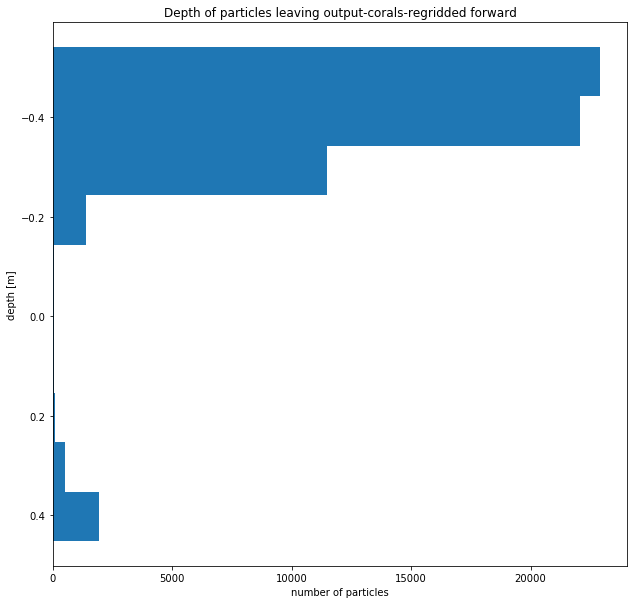

In [92]:
fig = plt.figure(figsize=(10.3,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('depth [m]')
plt.xlabel('number of particles')
ax.barh(bineds[:-1],np.sum(zzs,axis=0),height=(bineds[-1]-bineds[-2]))
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb)

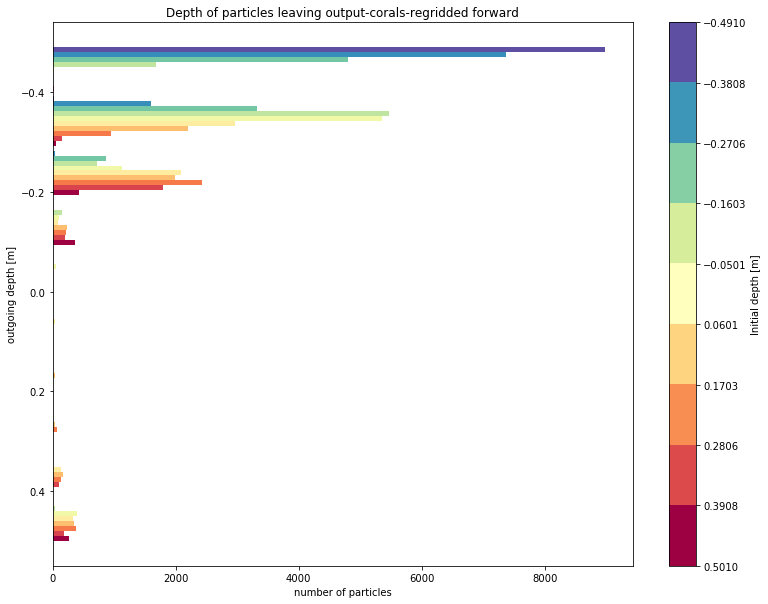

In [93]:
bounds = np.linspace(bineds[0], bineds[-1], nbins)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
partcolor = cm.ScalarMappable(norm=norm,cmap=cmap)

fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('outgoing depth [m]')
plt.xlabel('number of particles')
barwidth = (bineds[-1]-bineds[-2])/nbins
for i in range(len(zzs)):
    ax.barh(bineds[:-1]+i*barwidth,width=zzs[i],color=colors[i],align='edge',height=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb+'-absdepth')

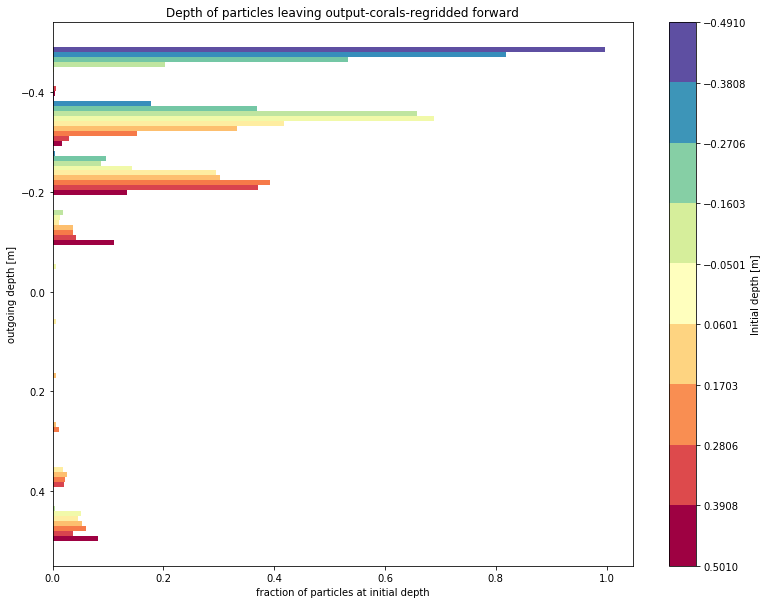

In [94]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('outgoing depth [m]')
plt.xlabel('fraction of particles at initial depth')
barwidth = (bineds[-1]-bineds[-2])/nbins
for i in range(len(zzs)):
    ax.barh(bineds[:-1]+i*barwidth,width=zzs[i]/zs[i],color=colors[i],align='edge',height=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb+'-perdepth')

In [95]:
binedst = np.linspace(0,np.max(t)+1,nbins+1)
tm = t[t[:,-1].mask]
tt = np.zeros(len(tm))                                  # outgoing times for each particle
for i in range(len(tt)):
    tx = tm[i][~tm[i].mask]
    if len(tx)<len(t[0]):
        if fb == 'forward':
            tt[i] = tx[-1]                             # last time
        else:
            tt[i] = tx[0]-tx[-1]             # runtime - last time = time spent in domain

tts = np.zeros((nbins,nbins))
for i in range(len(tts)):
    mask = (bineds[i]<=zm[:,0]) & (zm[:,0]<=bineds[i+1])
    tts[i,:],binedst = np.histogram(tt[mask],binedst)

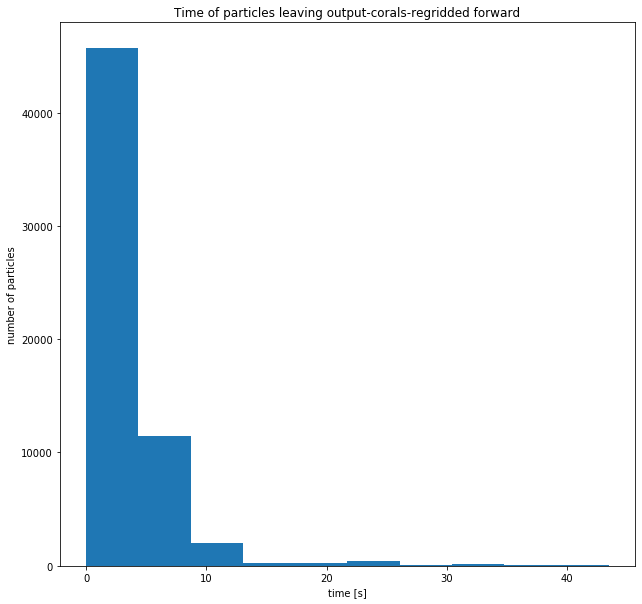

In [96]:
fig = plt.figure(figsize=(10.3,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('time [s]')
wt,wr,ww = ax.hist(tt)
plt.savefig('Figures/time-'+filename+'-'+fb)

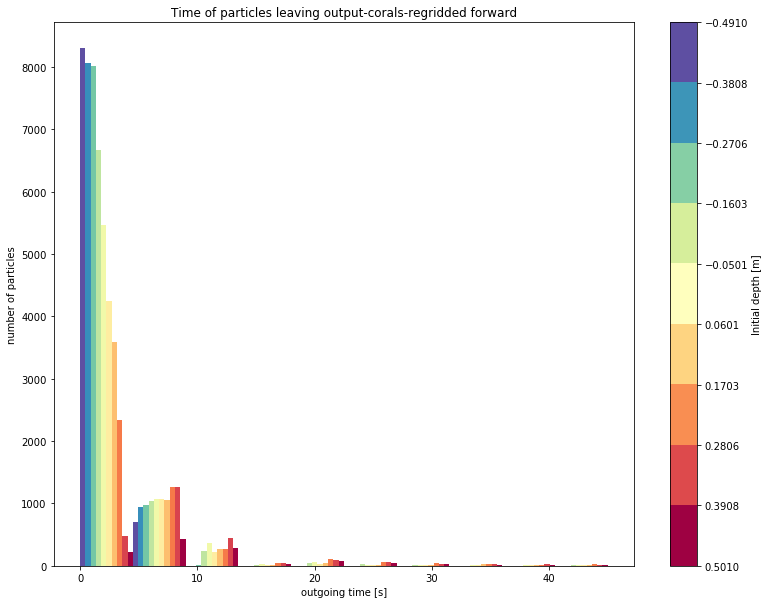

In [97]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('outgoing time [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(tts)):
    ax.bar(binedst[:-1]+i*barwidth,tts[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/time-'+filename+'-'+fb+'-absdepth')

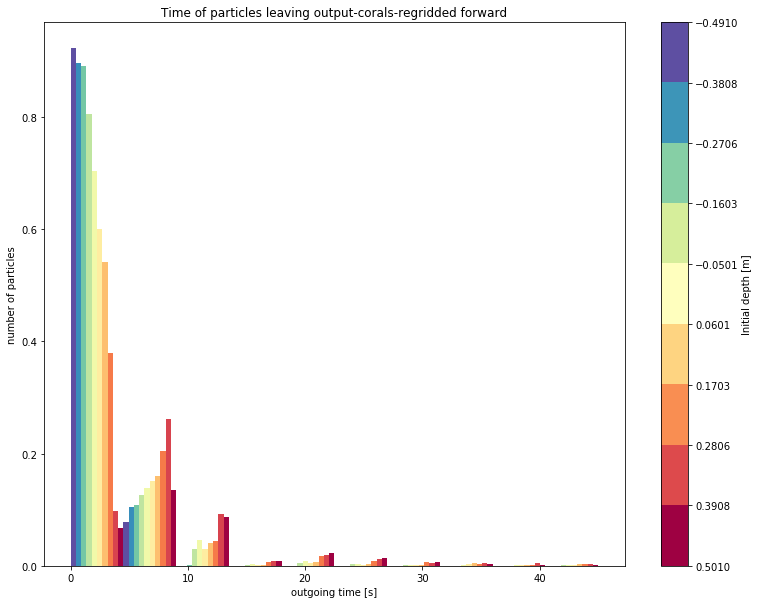

In [98]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('outgoing time [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(tts)):
    ax.bar(binedst[:-1]+i*barwidth,tts[i]/zs[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/time-'+filename+'-'+fb+'-perdepth')

First we look at the beaching of the particles through time by counting how many final distances travelled are zero at each timestep.

In [99]:
ct = np.zeros(len(b[0]))
ct[-1] = np.count_nonzero(b[:,-1]==0)
beac = np.zeros((int(ct[-1]),2),dtype=np.int64)
beac[:,1] = np.nonzero(b[:,-1]==0)[0]
bn = b[beac[:,1]]
for i in range(len(bn)):
    cn = 0
    for j in np.arange(len(bn[i])-2,-1,-1):
        if bn[i,j] == 0:
            cn += 1
        else:
            break
    beac[i,0] = 44 - cn/10
for i in np.arange(len(b[0])-2,-1,-1): # each timestep
    ct[i] = np.count_nonzero(b[:,i]==0) #count how many values are zero            

In [100]:
zn = z[beac[:,1]]
beacs = np.zeros((nbins,nbins))
for i in range(len(beacs)):
    mask = (bineds[i]<=zn[:,0]) & (zn[:,0]<=bineds[i+1])
    beacs[i,:],taway = np.histogram(beac[:,0][mask],binedst)

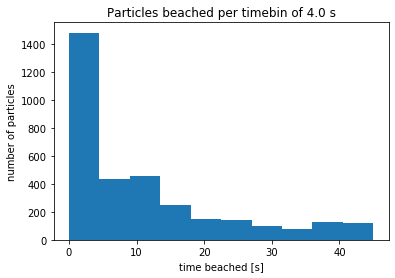

In [101]:
plt.hist(beac[:,0],binedst)
plt.title('Particles beached per timebin of '+str(round(binedst[-1]-binedst[-2]))+' s')
plt.ylabel('number of particles')
plt.xlabel('time beached [s]')
plt.ylim(bottom=0)
plt.savefig('Figures/beachedtime-'+filename+'-'+fb)

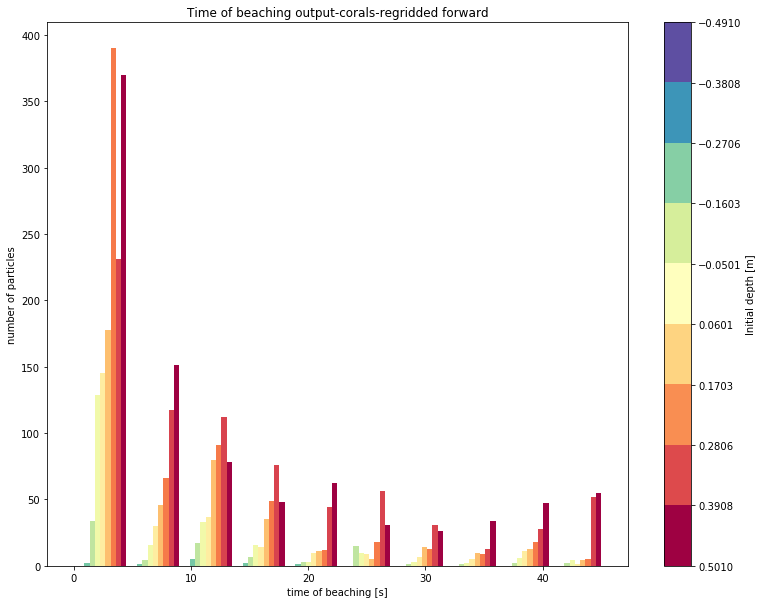

In [102]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of beaching '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('time of beaching [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(beacs)):
    ax.bar(binedst[:-1]+i*barwidth,beacs[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/beachedtime-'+filename+'-'+fb+'-absdepth')

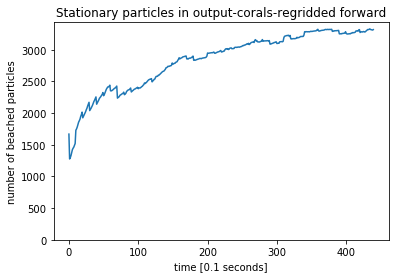

In [103]:
plt.plot(ct[1:])
plt.title('Stationary particles in '+filename+' '+fb)
plt.ylabel('number of beached particles')
plt.xlabel('time [0.1 seconds]')
plt.ylim(bottom=0)
plt.savefig('Figures/beached-'+filename+'-'+fb)

Finally, we are going to create plots to show the particles, coloured by their initial height.

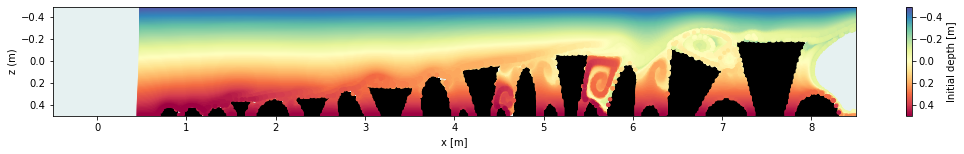

In [104]:
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.set_facecolor(coralcolor)
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.dense_r)
cb = ax.scatter(x[:,10], z[:,10], c=z[:,0], s=10, marker="o",cmap=cmap)
cbar = fig.colorbar(cb,label='Initial depth [m]')
cbar.ax.invert_yaxis()
ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
plt.show()

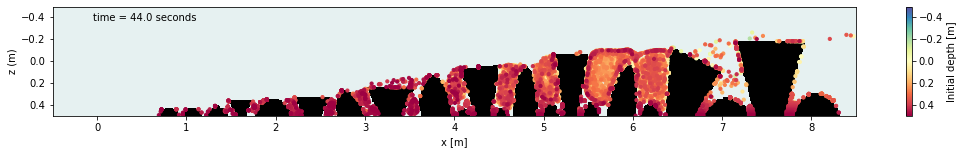

In [105]:
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.set_facecolor(coralcolor)
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.dense_r)
sc = ax.scatter(x[:,0], z[:,0], c=z[:,0],s=10, marker="o",cmap=cmap)
topleft = 0.05
if fb == 'backward':
    topleft = 0.8
time_text = ax.text(topleft, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
cbar = fig.colorbar(sc,label='Initial depth [m]')
cbar.ax.invert_yaxis()

def animate(i,fig,sc):
    sc.set_offsets(np.c_[x[:,i], z[:,i]])
    ts = i*outputdt.microseconds/1000000
    if fb == 'b':
        ts = ts*-1
    time_text.set_text('time = %.1f seconds' % ts)
    return sc, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc),
                               frames = len(x[0]), blit=True)
anim.save('Figures/'+filename+'-'+str(runtime.seconds)+'-'+fb+'.mp4')
plt.show()